- Problem: Loan default prediction problem.
- Objective: Predict whether future loan applicants are likely to default.  
- Approach: Supervised classification problem
- Dataset: Contains 860,000 observations and 150 variables.- Features: Include credit scores, financing queries, address details, collections, etc.
- Goal: Develop accurate predictive models to assist finance companies in making informed decisions, such as denying loans or adjusting loan terms..- Importance: Mitigate financial risks associated with loan defaults.ults.

In [1]:

import xgboost as xgb
import pandas as pd

from sklearn.metrics import accuracy_score

In [2]:
train_data = pd.read_csv("train.csv")
valid_data=pd.read_csv("valid.csv")
test_data=pd.read_csv("X_test.csv")

In [3]:
train_data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_last_payment_amount', 'disbursement_method',
       'debt_settlement_flag', 'debt_settlement_flag_date',
       'settlement_status', 'settlement_date', 'settlement_amount',
       'settlement_percentage', 'settlement_term', 'loan_status'],
      dtype='object', length=145)

In [4]:
data_types = train_data.dtypes

In [5]:
categorical_columns = data_types[data_types == 'object'].index.tolist()
print(categorical_columns)

['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'last_credit_pull_d', 'application_type', 'verification_status_joint', 'sec_app_earliest_cr_line', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_loan_status', 'disbursement_method', 'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date']


In [6]:
print(len(categorical_columns))

34


## Data Preprocessing

#### Cleaning data

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517788 entries, 0 to 517787
Columns: 145 entries, id to loan_status
dtypes: float64(106), int64(5), object(34)
memory usage: 572.8+ MB


In [8]:
train_data.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0 NaN        NaN      14000        14000          14000.0   36 months   
1 NaN        NaN       2000         2000           2000.0   36 months   
2 NaN        NaN       5000         5000           4750.0   36 months   
3 NaN        NaN      20600        20600          20600.0   36 months   
4 NaN        NaN      10000        10000          10000.0   36 months   

   int_rate  installment grade sub_grade  ... hardship_last_payment_amount  \
0      7.35       434.53     A        A4  ...                          NaN   
1     16.29        70.61     D        D2  ...                          NaN   
2      7.39       155.28     A        A4  ...                          NaN   
3     11.99       684.12     B        B5  ...                          NaN   
4      7.39       310.56     A        A4  ...                          NaN   

  disbursement_method debt_settlement_flag  debt_settlement_flag_date  \
0                Cash                    N                        NaN   
1                Cash                    N                        NaN   
2                Cash                    N                        NaN   
3                Cash                    N                        NaN   
4                Cash                    N                        NaN   

  settlement_status settlement_date settlement_amount  settlement_percentage  \
0               NaN             NaN               NaN                    NaN   
1               NaN             NaN               NaN                    NaN   
2               NaN             NaN               NaN                    NaN   
3               NaN             NaN               NaN                    NaN   
4               NaN             NaN               NaN                    NaN   

  settlement_term loan_status  
0             NaN           1  
1             NaN           1  
2             NaN           1  
3             NaN           1  
4             NaN           1  

[5 rows x 145 columns]

 **Info about missing values**

In [9]:
train_data.isnull().sum()
valid_data.isnull().sum()

id                       172596
member_id                172596
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
                          ...  
settlement_date          166215
settlement_amount        166215
settlement_percentage    166215
settlement_term          166215
loan_status                   0
Length: 145, dtype: int64

**Handling missing values by eliminating**

In [10]:

threshold = 0.8
null_counts = train_data.isnull().sum()
columns_to_drop = null_counts[null_counts / len(train_data) > threshold].index
train_data_cleaned = train_data.drop(columns=columns_to_drop)
print(train_data_cleaned.head())

   loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment  \
0      14000        14000          14000.0   36 months      7.35       434.53   
1       2000         2000           2000.0   36 months     16.29        70.61   
2       5000         5000           4750.0   36 months      7.39       155.28   
3      20600        20600          20600.0   36 months     11.99       684.12   
4      10000        10000          10000.0   36 months      7.39       310.56   

  grade sub_grade           emp_title emp_length  ... pub_rec_bankruptcies  \
0     A        A4          Paralegal      1 year  ...                  0.0   
1     D        D2                 NaN        NaN  ...                  1.0   
2     A        A4               owner    4 years  ...                  0.0   
3     B        B5                 NaN        NaN  ...                  0.0   
4     A        A4  Senior UX designer   < 1 year  ...                  0.0   

   tax_liens tot_hi_cred_lim total_bal_ex_mo

In [11]:

threshold = 0.8
null_counts = valid_data.isnull().sum()
columns_to_drop = null_counts[null_counts / len(valid_data) > threshold].index
valid_data_cleaned = valid_data.drop(columns=columns_to_drop)
print(valid_data_cleaned.head())

   loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment  \
0      14575        14575          14575.0   60 months     17.57       366.71   
1      10000        10000          10000.0   36 months     13.59       339.79   
2      17000        17000          17000.0   36 months     13.35       575.67   
3       4500         4500           4500.0   36 months      9.93       145.06   
4       6250         6250           6250.0   36 months     12.99       210.56   

  grade sub_grade           emp_title emp_length  ... pub_rec_bankruptcies  \
0     D        D2        Case Manager  10+ years  ...                  0.0   
1     C        C2       Truck Driver     3 years  ...                  1.0   
2     C        C2  Sr Project Manager  10+ years  ...                  0.0   
3     B        B2              Driver  10+ years  ...                  1.0   
4     B        B4            operator  10+ years  ...                  0.0   

   tax_liens tot_hi_cred_lim total_bal_ex_mo

In [12]:

threshold = 0.8
null_counts = test_data.isnull().sum()
columns_to_drop = null_counts[null_counts / len(test_data) > threshold].index
test_data_cleaned = test_data.drop(columns=columns_to_drop)
print(test_data_cleaned.head())

   loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment  \
0       8100         8100           8100.0   36 months     11.47       267.00   
1      10000        10000          10000.0   36 months     12.99       336.90   
2       9450         9450           9450.0   36 months     13.67       321.47   
3      25000        25000          24975.0   36 months     17.49       897.43   
4      16000        16000          16000.0   60 months     14.99       380.56   

  grade sub_grade            emp_title emp_length  ... percent_bc_gt_75  \
0     B        B5              Teacher    2 years  ...             50.0   
1     C        C2                Owner    2 years  ...             50.0   
2     B        B5              Teacher  10+ years  ...              0.0   
3     D        D5  State of California  10+ years  ...              NaN   
4     C        C5               Driver  10+ years  ...             36.4   

   pub_rec_bankruptcies tax_liens tot_hi_cred_lim total_bal_ex

In [13]:
train_data_cleaned = train_data_cleaned.dropna(thresh=72)

In [14]:
valid_data_cleaned = valid_data_cleaned.dropna(thresh=72)

In [15]:
print(train_data_cleaned.head())

   loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment  \
0      14000        14000          14000.0   36 months      7.35       434.53   
1       2000         2000           2000.0   36 months     16.29        70.61   
2       5000         5000           4750.0   36 months      7.39       155.28   
3      20600        20600          20600.0   36 months     11.99       684.12   
4      10000        10000          10000.0   36 months      7.39       310.56   

  grade sub_grade           emp_title emp_length  ... pub_rec_bankruptcies  \
0     A        A4          Paralegal      1 year  ...                  0.0   
1     D        D2                 NaN        NaN  ...                  1.0   
2     A        A4               owner    4 years  ...                  0.0   
3     B        B5                 NaN        NaN  ...                  0.0   
4     A        A4  Senior UX designer   < 1 year  ...                  0.0   

   tax_liens tot_hi_cred_lim total_bal_ex_mo

In [21]:
train_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 491909 entries, 0 to 517787
Columns: 105 entries, loan_amnt to loan_status
dtypes: float64(79), int64(5), object(21)
memory usage: 397.8+ MB


In [22]:
train_data_cleaned.columns


Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       ...
       'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
       'hardship_flag', 'disbursement_method', 'debt_settlement_flag',
       'loan_status'],
      dtype='object', length=105)

**Filling missing values based on the type of variable using central tendancy measures**

In [16]:
# Iterate through each column
for column in train_data_cleaned.columns:
    # Check if column data type is object (categorical)
    if train_data_cleaned[column].dtype == 'object':
        # Fill missing categorical values with mode
        mode_value = train_data_cleaned[column].mode()[0]
        train_data_cleaned[column] = train_data_cleaned[column].fillna(mode_value)
        
    else:
        # Fill missing numerical values with median
        median_value = train_data_cleaned[column].median()
        train_data_cleaned[column] = train_data_cleaned[column].fillna(median_value)

print(train_data_cleaned)


        loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0           14000        14000          14000.0   36 months      7.35   
1            2000         2000           2000.0   36 months     16.29   
2            5000         5000           4750.0   36 months      7.39   
3           20600        20600          20600.0   36 months     11.99   
4           10000        10000          10000.0   36 months      7.39   
...           ...          ...              ...         ...       ...   
517783       3600         3600           3600.0   36 months     20.31   
517784       8000         8000           8000.0   36 months     13.99   
517785      14000        14000          13925.0   60 months     18.25   
517786       5200         5200           5200.0   36 months     17.27   
517787       8000         8000           8000.0   36 months      7.12   

        installment grade sub_grade                           emp_title  \
0            434.53     A        A4             

In [17]:
# Iterate through each column
for column in valid_data_cleaned.columns:
    # Check if column data type is object (categorical)
    if valid_data_cleaned[column].dtype == 'object':
        # Fill missing categorical values with mode
        mode_value = valid_data_cleaned[column].mode()[0]
        valid_data_cleaned[column] = valid_data_cleaned[column].fillna(mode_value)
        
    else:
        # Fill missing numerical values with median
        median_value = valid_data_cleaned[column].median()
        valid_data_cleaned[column] = valid_data_cleaned[column].fillna(median_value)

print(valid_data_cleaned)


        loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0           14575        14575          14575.0   60 months     17.57   
1           10000        10000          10000.0   36 months     13.59   
2           17000        17000          17000.0   36 months     13.35   
3            4500         4500           4500.0   36 months      9.93   
4            6250         6250           6250.0   36 months     12.99   
...           ...          ...              ...         ...       ...   
172591      30000        30000          30000.0   36 months     22.90   
172592       5000         5000           5000.0   36 months     12.49   
172593      13000        13000          13000.0   36 months      7.89   
172594      35000        35000          35000.0   36 months     12.99   
172595       4800         4800           4800.0   36 months      8.19   

        installment grade sub_grade            emp_title emp_length  ...  \
0            366.71     D        D2         Cas

In [18]:
# Iterate through each column
for column in test_data_cleaned.columns:
    # Check if column data type is object (categorical)
    if test_data_cleaned[column].dtype == 'object':
        # Fill missing categorical values with mode
        mode_value = test_data_cleaned[column].mode()[0]
        test_data_cleaned[column] = test_data_cleaned[column].fillna(mode_value)
        
    else:
        # Fill missing numerical values with median
        median_value = test_data_cleaned[column].median()
        test_data_cleaned[column] = test_data_cleaned[column].fillna(median_value)

print(test_data_cleaned)


        loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0            8100         8100           8100.0   36 months     11.47   
1           10000        10000          10000.0   36 months     12.99   
2            9450         9450           9450.0   36 months     13.67   
3           25000        25000          24975.0   36 months     17.49   
4           16000        16000          16000.0   60 months     14.99   
...           ...          ...              ...         ...       ...   
172591       7000         7000           7000.0   36 months     18.25   
172592      12500        12500          12500.0   36 months     12.49   
172593      30000        30000          30000.0   36 months      7.89   
172594       3500         3500           3500.0   36 months      8.59   
172595      12000        12000          12000.0   36 months      5.32   

        installment grade sub_grade            emp_title emp_length  ...  \
0            267.00     B        B5            

#### 
Label Encoding

In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:

# Identify categorical columns
categorical_columns = train_data_cleaned.select_dtypes(include=['object']).columns

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns
for column in categorical_columns:
    train_data_cleaned[column] = label_encoder.fit_transform(train_data_cleaned[column])

# Now, categorical data is encoded with numeric values


In [21]:

# Identify categorical columns
categorical_columns = valid_data_cleaned.select_dtypes(include=['object']).columns

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns
for column in categorical_columns:
    valid_data_cleaned[column] = label_encoder.fit_transform(valid_data_cleaned[column])

# Now, categorical data is encoded with numeric values


In [22]:

# Identify categorical columns
categorical_columns = test_data_cleaned.select_dtypes(include=['object']).columns

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns
for column in categorical_columns:
    test_data_cleaned[column] = label_encoder.fit_transform(test_data_cleaned[column])

# Now, categorical data is encoded with numeric values


In [23]:
# Check the data types of each column
data_types = train_data_cleaned.dtypes

# Filter out non-numeric columns
numeric_columns = data_types[data_types != 'object'].index

# Check if there are any non-numeric columns
non_numeric_columns = data_types[data_types == 'object'].index

if len(non_numeric_columns) == 0:
    print("All columns are numeric.")
else:
    print("Non-numeric columns:", non_numeric_columns)
train_data_cleaned.info()

All columns are numeric.
<class 'pandas.core.frame.DataFrame'>
Index: 491909 entries, 0 to 517787
Columns: 105 entries, loan_amnt to loan_status
dtypes: float64(79), int32(21), int64(5)
memory usage: 358.4 MB


In [24]:
# Check the data types of each column
data_types = valid_data_cleaned.dtypes

# Filter out non-numeric columns
numeric_columns = data_types[data_types != 'object'].index

# Check if there are any non-numeric columns
non_numeric_columns = data_types[data_types == 'object'].index

if len(non_numeric_columns) == 0:
    print("All columns are numeric.")
else:
    print("Non-numeric columns:", non_numeric_columns)
valid_data_cleaned.info()

All columns are numeric.
<class 'pandas.core.frame.DataFrame'>
Index: 163908 entries, 0 to 172595
Columns: 105 entries, loan_amnt to loan_status
dtypes: float64(79), int32(21), int64(5)
memory usage: 119.4 MB


#### Data Scaling

In [25]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Scale the data
scaled_data = scaler.fit_transform(train_data_cleaned)

# Now, scaled_data contains the scaled features


In [26]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Scale the data
scaled_data = scaler.fit_transform(valid_data_cleaned)

# Now, scaled_data contains the scaled features


In [27]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Scale the data
scaled_data = scaler.fit_transform(test_data_cleaned)

# Now, scaled_data contains the scaled features


In [25]:
train_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 491909 entries, 0 to 517787
Columns: 105 entries, loan_amnt to loan_status
dtypes: float64(79), int32(21), int64(5)
memory usage: 358.4 MB


#### Split data as X_train And y_train

In [28]:
X_train = train_data_cleaned.iloc[:, :-1]  # Features (all columns except the last one)
y_train = train_data_cleaned.iloc[:, -1]   # Target column (last column)

In [29]:
X_valid = valid_data_cleaned.iloc[:, :-1]  # Features (all columns except the last one)
y_valid = valid_data_cleaned.iloc[:, -1]   # Target column (last column)

In [30]:
X_test = test_data_cleaned

In [30]:
print(y_train.dtype)


int64


In [31]:
print(y_valid.dtype)


int64


**Identifying outliers**

In [145]:
# Visualize the data before handling outliers and smoothing
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train)
plt.title('Boxplot of Data before Outlier Handling and Smoothing')
plt.xticks(rotation=90)
plt.show()

KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

In [227]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 491909 entries, 0 to 517787
Columns: 104 entries, loan_amnt to debt_settlement_flag
dtypes: float64(79), int32(21), int64(4)
memory usage: 354.7 MB


In [228]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 163908 entries, 0 to 172595
Columns: 104 entries, loan_amnt to debt_settlement_flag
dtypes: float64(79), int32(21), int64(4)
memory usage: 118.2 MB


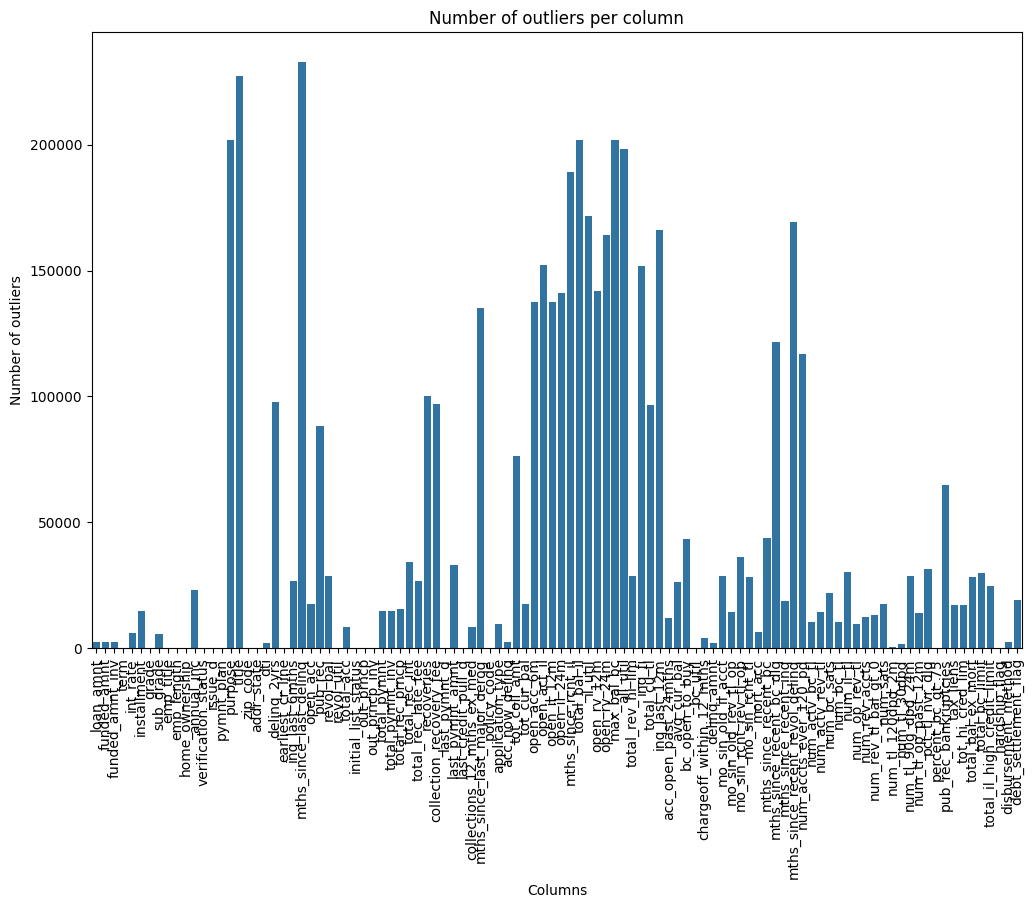

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the number of outliers per column
outliers = {}
for col in X_train.columns:
    q1 = X_train[col].quantile(0.25)
    q3 = X_train[col].quantile(0.75)
    iqr = q3 - q1
    outliers[col] = len(X_train[(X_train[col] < q1 - 1.5 * iqr) | (X_train[col] > q3 + 1.5 * iqr)])

# Plot the number of outliers per column
plt.figure(figsize=(12, 8))
sns.barplot(x=list(outliers.keys()), y=list(outliers.values()))
plt.title('Number of outliers per column')
plt.xlabel('Columns')
plt.ylabel('Number of outliers')
plt.xticks(rotation=90)
plt.show()


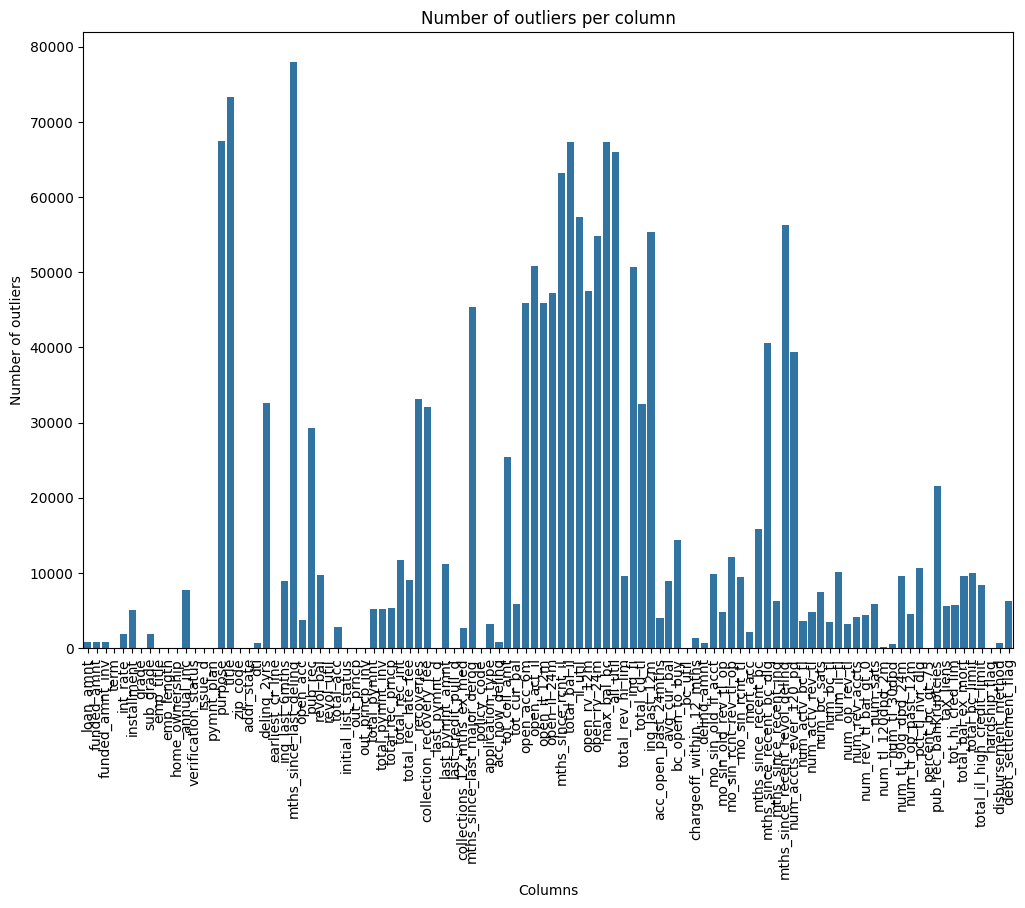

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the number of outliers per column
outliers = {}
for col in X_valid.columns:
    q1 = X_valid[col].quantile(0.25)
    q3 = X_valid[col].quantile(0.75)
    iqr = q3 - q1
    outliers[col] = len(X_valid[(X_valid[col] < q1 - 1.5 * iqr) | (X_valid[col] > q3 + 1.5 * iqr)])

# Plot the number of outliers per column
plt.figure(figsize=(12, 8))
sns.barplot(x=list(outliers.keys()), y=list(outliers.values()))
plt.title('Number of outliers per column')
plt.xlabel('Columns')
plt.ylabel('Number of outliers')
plt.xticks(rotation=90)
plt.show()


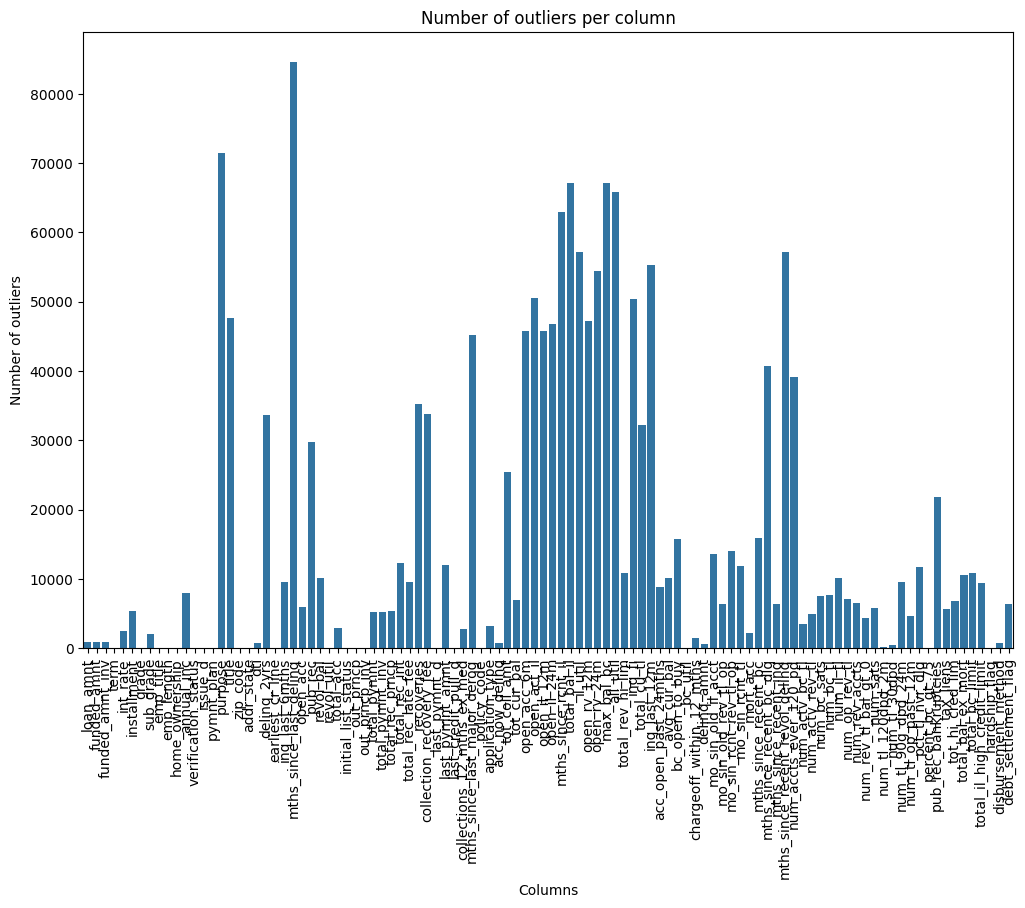

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the number of outliers per column
outliers = {}
for col in X_test.columns:
    q1 = X_test[col].quantile(0.25)
    q3 = X_test[col].quantile(0.75)
    iqr = q3 - q1
    outliers[col] = len(X_test[(X_test[col] < q1 - 1.5 * iqr) | (X_test[col] > q3 + 1.5 * iqr)])

# Plot the number of outliers per column
plt.figure(figsize=(12, 8))
sns.barplot(x=list(outliers.keys()), y=list(outliers.values()))
plt.title('Number of outliers per column')
plt.xlabel('Columns')
plt.ylabel('Number of outliers')
plt.xticks(rotation=90)
plt.show()


**Handling Outliers Using Binning**

In [34]:
# Smooth columns with more than 50,000 outliers
threshold = 50000
smoothed_columns = []
columns_to_drop = []  # Initialize list to store columns to drop

for col in X_train.columns:
    if outliers[col] > threshold:
        num_bins = 20  # Adjust the number of bins here
        bin_edges = pd.cut(X_train[col], bins=num_bins, labels=False)
        bin_midpoints = (bin_edges + 0.5) * (X_train[col].max() - X_train[col].min()) / num_bins
        smoothed_columns.append(pd.Series(bin_midpoints, name=col + '_smoothed'))
        columns_to_drop.append(col)  # Add original column to columns_to_drop list

# Concatenate smoothed columns to the original DataFrame
X_train = pd.concat([X_train] + smoothed_columns, axis=1)

# Drop the original columns from the DataFrame
X_train = X_train.drop(columns=columns_to_drop)


In [35]:
# Smooth columns with more than 50,000 outliers
threshold = 50000
smoothed_columns = []
columns_to_drop = []  # Initialize list to store columns to drop

for col in X_valid.columns:
    if outliers[col] > threshold:
        num_bins = 20  # Adjust the number of bins here
        bin_edges = pd.cut(X_valid[col], bins=num_bins, labels=False)
        bin_midpoints = (bin_edges + 0.5) * (X_valid[col].max() - X_valid[col].min()) / num_bins
        smoothed_columns.append(pd.Series(bin_midpoints, name=col + '_smoothed'))
        columns_to_drop.append(col)  # Add original column to columns_to_drop list

# Concatenate smoothed columns to the original DataFrame
X_valid = pd.concat([X_valid] + smoothed_columns, axis=1)

# Drop the original columns from the DataFrame
X_valid = X_valid.drop(columns=columns_to_drop)


In [36]:
# Smooth columns with more than 50,000 outliers
threshold = 50000
smoothed_columns = []
columns_to_drop = []  # Initialize list to store columns to drop

for col in X_test.columns:
    if outliers[col] > threshold:
        num_bins = 20  # Adjust the number of bins here
        bin_edges = pd.cut(X_test[col], bins=num_bins, labels=False)
        bin_midpoints = (bin_edges + 0.5) * (X_test[col].max() - X_test[col].min()) / num_bins
        smoothed_columns.append(pd.Series(bin_midpoints, name=col + '_smoothed'))
        columns_to_drop.append(col)  # Add original column to columns_to_drop list

# Concatenate smoothed columns to the original DataFrame
X_test = pd.concat([X_test] + smoothed_columns, axis=1)

# Drop the original columns from the DataFrame
X_test = X_test.drop(columns=columns_to_drop)


In [153]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 491909 entries, 0 to 517787
Columns: 104 entries, loan_amnt to mths_since_recent_revol_delinq_smoothed
dtypes: float64(81), int32(19), int64(4)
memory usage: 358.4 MB


In [154]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 163908 entries, 0 to 172595
Columns: 104 entries, loan_amnt to mths_since_recent_revol_delinq_smoothed
dtypes: float64(81), int32(19), int64(4)
memory usage: 119.4 MB


In [37]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172596 entries, 0 to 172595
Columns: 104 entries, loan_amnt to mths_since_recent_revol_delinq_smoothed
dtypes: float64(80), int32(20), int64(4)
memory usage: 123.8 MB


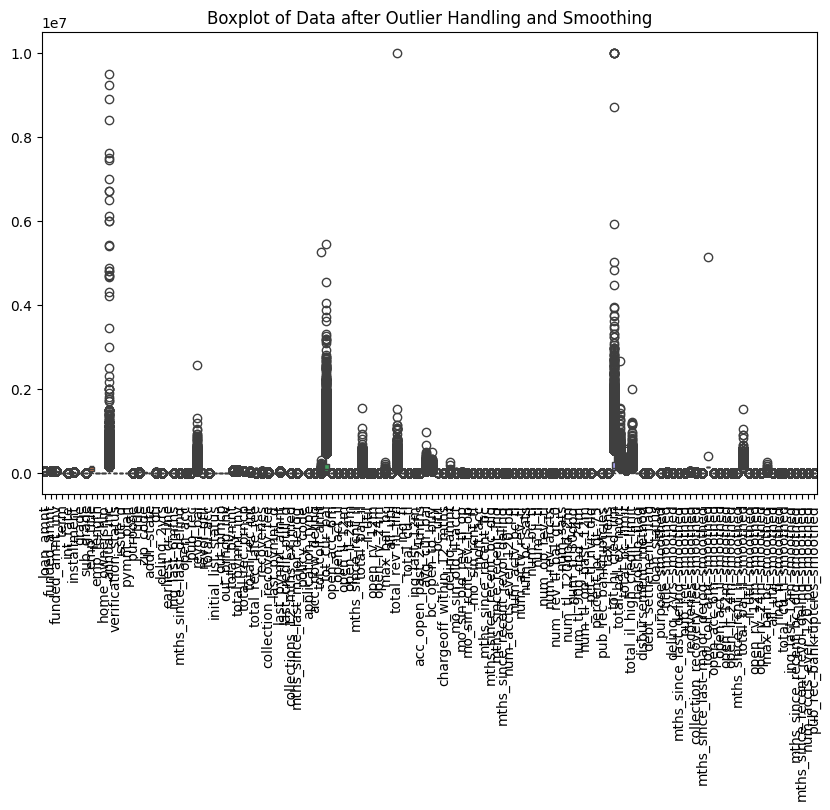

In [73]:
# Visualize the data after handling outliers and smoothing
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train)
plt.title('Boxplot of Data after Outlier Handling and Smoothing')
plt.xticks(rotation=90)
plt.show()


In [150]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 491909 entries, 0 to 517787
Columns: 104 entries, loan_amnt to pub_rec_bankruptcies_smoothed
dtypes: float64(81), int32(19), int64(4)
memory usage: 358.4 MB


## Feature Engineering

In [38]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression  # You can replace this with any estimator suitable for your problem

# Initialize your estimator (e.g., Linear Regression)
estimator = LinearRegression()

# Initialize RFE with the estimator and the number of features you want to retain
# For your case, you want to reduce features to 20
rfe = RFE(estimator, n_features_to_select=50)

# Fit RFE to your data
rfe.fit(X_train, y_train)  # X is your feature matrix, y is your target variable

# Get the selected features
selected_features = X_train.columns[rfe.support_]

# You can then use selected_features to subset your original feature matrix X
X_selected = X_train[selected_features]

# Train your model using the selected features
# Example:
# model.fit(X_selected, y)


In [39]:
# List of selected features
print(selected_features.tolist())

['term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc', 'initial_list_status', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'application_type', 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'total_cu_tl', 'acc_open_past_24mths', 'chargeoff_within_12_mths', 'mort_acc', 'num_actv_rev_tl', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies', 'tax_liens', 'disbursement_method', 'debt_settlement_flag', 'purpose_smoothed', 'open_act_il_smoothed', 'open_rv_24m_smoothed', 'all_util_smoothed', 'inq_fi_smoothed']


In [40]:
# Subset the validation data with the selected features
X_valid_selected = X_valid[selected_features]

In [41]:
X_test_selected = X_test[selected_features]


In [42]:
print(X_test.columns)


Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       ...
       'open_act_il_smoothed', 'mths_since_rcnt_il_smoothed',
       'total_bal_il_smoothed', 'il_util_smoothed', 'open_rv_24m_smoothed',
       'max_bal_bc_smoothed', 'all_util_smoothed', 'inq_fi_smoothed',
       'inq_last_12m_smoothed', 'mths_since_recent_revol_delinq_smoothed'],
      dtype='object', length=104)


**Mutual Information**

In [43]:
discrete_features = X_selected.dtypes == int

In [44]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [45]:
X = X_selected.copy()
y = y_train
mi_scores = make_mi_scores(X, y)

total_rec_prncp         0.595134
recoveries              0.310237
debt_settlement_flag    0.150063
total_pymnt             0.121548
disbursement_method     0.101274
application_type        0.099190
last_credit_pull_d      0.090014
term                    0.087465
grade                   0.070125
initial_list_status     0.055213
sub_grade               0.054302
int_rate                0.052013
home_ownership          0.047156
verification_status     0.040485
installment             0.040457
total_rec_int           0.030907
total_rec_late_fee      0.027513
emp_length              0.017189
dti                     0.007142
acc_open_past_24mths    0.006229
Name: MI Scores, dtype: float64


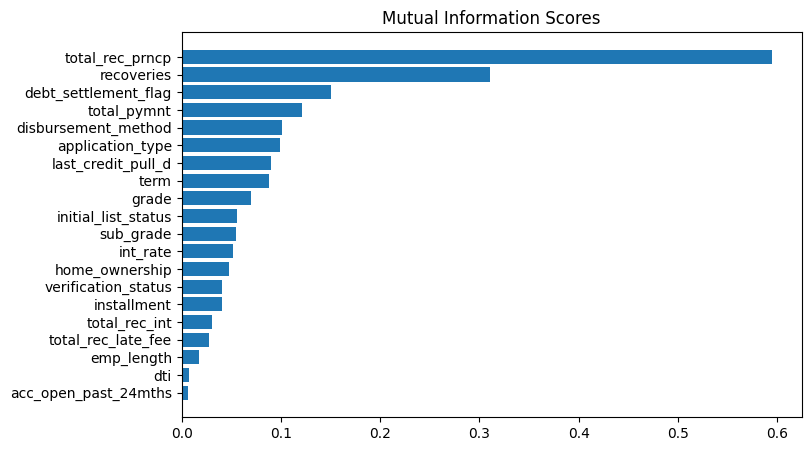

In [46]:
print(mi_scores.head(20))

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))


open_acc                      0.001856
open_acc_6m                   0.001696
chargeoff_within_12_mths      0.001642
open_act_il_smoothed          0.001616
open_rv_12m                   0.001470
num_tl_90g_dpd_24m            0.001372
num_bc_tl                     0.001237
num_rev_accts                 0.001068
total_acc                     0.001024
tax_liens                     0.000789
collections_12_mths_ex_med    0.000641
num_il_tl                     0.000537
open_il_24m                   0.000402
open_il_12m                   0.000360
total_cu_tl                   0.000298
num_tl_30dpd                  0.000089
num_tl_120dpd_2m              0.000000
pub_rec                       0.000000
num_op_rev_tl                 0.000000
delinq_2yrs                   0.000000
Name: MI Scores, dtype: float64


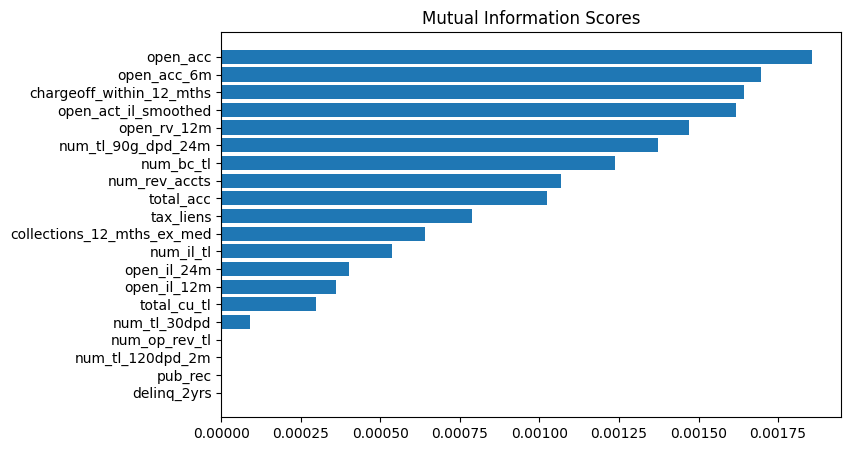

In [152]:

print(mi_scores.tail(20))  # uncomment to see bottom 20
plt.figure(dpi=100, figsize=(8, 5))

plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

In [47]:
# List of features to remove
features_to_remove = ['num_tl_120dpd_2m', 'pub_rec', 'num_op_rev_tl', 'delinq_2yrs']

# Remove features from the dataset
X_selected = X_selected.drop(features_to_remove, axis=1)

In [48]:
# Calculate the ratio of open accounts to total accounts
X_selected['open_acc_to_total_acc_ratio'] = X_selected['open_acc'] / X_selected['total_acc']

# Drop the used features
X_selected = X_selected.drop(['open_acc', 'total_acc'], axis=1)


In [49]:
# Calculate the ratio of open accounts to total accounts
X_valid_selected['open_acc_to_total_acc_ratio'] = X_valid_selected['open_acc'] / X_valid_selected['total_acc']

# Drop the used features
X_valid_selected = X_valid_selected.drop(['open_acc', 'total_acc'], axis=1)


C:\Users\MadaraMendis\AppData\Local\Temp\ipykernel_20072\2300523747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_selected['open_acc_to_total_acc_ratio'] = X_valid_selected['open_acc'] / X_valid_selected['total_acc']


In [50]:
# Calculate the ratio of open accounts to total accounts
X_test_selected['open_acc_to_total_acc_ratio'] = X_test_selected['open_acc'] / X_test_selected['total_acc']

# Drop the used features
X_test_selected = X_test_selected.drop(['open_acc', 'total_acc'], axis=1)


C:\Users\MadaraMendis\AppData\Local\Temp\ipykernel_20072\1909922967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_selected['open_acc_to_total_acc_ratio'] = X_test_selected['open_acc'] / X_test_selected['total_acc']


In [51]:
X_valid_selected = X_valid_selected.drop(features_to_remove, axis=1)

In [52]:
X_test_selected = X_test_selected.drop(features_to_remove, axis=1)

In [50]:
X_valid_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 163908 entries, 0 to 172595
Data columns (total 45 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   term                         163908 non-null  int32  
 1   int_rate                     163908 non-null  float64
 2   installment                  163908 non-null  float64
 3   grade                        163908 non-null  int32  
 4   sub_grade                    163908 non-null  int32  
 5   emp_length                   163908 non-null  int32  
 6   home_ownership               163908 non-null  int32  
 7   verification_status          163908 non-null  int32  
 8   dti                          163908 non-null  float64
 9   inq_last_6mths               163908 non-null  float64
 10  initial_list_status          163908 non-null  int32  
 11  total_pymnt                  163908 non-null  float64
 12  total_rec_prncp              163908 non-null  float64
 13  tota

In [52]:
X_selected .info()

<class 'pandas.core.frame.DataFrame'>
Index: 491909 entries, 0 to 517787
Data columns (total 45 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   term                         491909 non-null  int32  
 1   int_rate                     491909 non-null  float64
 2   installment                  491909 non-null  float64
 3   grade                        491909 non-null  int32  
 4   sub_grade                    491909 non-null  int32  
 5   emp_length                   491909 non-null  int32  
 6   home_ownership               491909 non-null  int32  
 7   verification_status          491909 non-null  int32  
 8   dti                          491909 non-null  float64
 9   inq_last_6mths               491909 non-null  float64
 10  initial_list_status          491909 non-null  int32  
 11  total_pymnt                  491909 non-null  float64
 12  total_rec_prncp              491909 non-null  float64
 13  tota

In [53]:
columns_to_remove = ['disbursement_method', 'num_tl_30dpd', 'chargeoff_within_12_mths']
X_modified = X_selected .drop(columns=columns_to_remove)

In [54]:
columns_to_remove = ['disbursement_method', 'num_tl_30dpd', 'chargeoff_within_12_mths']
X_valid_modified = X_valid_selected.drop(columns=columns_to_remove)

In [55]:
columns_to_remove = ['disbursement_method', 'num_tl_30dpd', 'chargeoff_within_12_mths']
X_test_modified = X_test_selected.drop(columns=columns_to_remove)

**Backward Feature Selection**

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split



# Initialize the model with all features
model = RandomForestClassifier()

# Train the initial model
model.fit(X_modified, y_train)

# Evaluate initial accuracy
y_pred = model.predict(X_valid_modified)
initial_accuracy = accuracy_score(y_valid, y_pred)

print("Initial Accuracy:", initial_accuracy)

# Perform backward feature selection
selected_features = list(X_modified.columns)
current_accuracy = initial_accuracy

while current_accuracy >= 0.999:
    # Store the current set of features and accuracy
    best_accuracy = current_accuracy
    best_feature = None
    
    # Iterate over each feature and remove it temporarily
    for feature in selected_features:
        # Temporarily remove the feature
        reduced_features = [f for f in selected_features if f != feature]
        
        # Train the model with reduced features
        model.fit(X_modified[reduced_features], y_train)
        
        # Evaluate accuracy
        y_pred = model.predict(X_valid_modified[reduced_features])
        accuracy = accuracy_score(y_valid, y_pred)
        
        # Update the best feature and accuracy if the accuracy improved
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_feature = feature
    
    # If a feature was found to improve accuracy, remove it
    if best_feature is not None:
        selected_features.remove(best_feature)
        current_accuracy = best_accuracy
    else:
        # No feature improved accuracy, exit the loop
        break

print("Final Selected Features:", selected_features)
print("Final Accuracy:", current_accuracy)


Initial Accuracy: 0.994692144373673
Final Selected Features: ['term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'dti', 'inq_last_6mths', 'initial_list_status', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'application_type', 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'total_cu_tl', 'acc_open_past_24mths', 'mort_acc', 'num_actv_rev_tl', 'num_bc_tl', 'num_il_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies', 'tax_liens', 'debt_settlement_flag', 'purpose_smoothed', 'open_act_il_smoothed', 'open_rv_24m_smoothed', 'all_util_smoothed', 'inq_fi_smoothed', 'open_acc_to_total_acc_ratio']
Final Accuracy: 0.994692144373673


In [57]:
X_train_reduced = X_modified[selected_features]

In [58]:
X_valid_reduced = X_valid_modified[selected_features]

In [59]:
X_test_reduced = X_test_modified[selected_features]

In [104]:
X_valid_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 163908 entries, 0 to 172595
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   term                         163908 non-null  int32  
 1   int_rate                     163908 non-null  float64
 2   installment                  163908 non-null  float64
 3   grade                        163908 non-null  int32  
 4   sub_grade                    163908 non-null  int32  
 5   emp_length                   163908 non-null  int32  
 6   home_ownership               163908 non-null  int32  
 7   verification_status          163908 non-null  int32  
 8   dti                          163908 non-null  float64
 9   inq_last_6mths               163908 non-null  float64
 10  initial_list_status          163908 non-null  int32  
 11  total_pymnt                  163908 non-null  float64
 12  total_rec_prncp              163908 non-null  float64
 13  tota

In [105]:
X_train_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 491909 entries, 0 to 517787
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   term                         491909 non-null  int32  
 1   int_rate                     491909 non-null  float64
 2   installment                  491909 non-null  float64
 3   grade                        491909 non-null  int32  
 4   sub_grade                    491909 non-null  int32  
 5   emp_length                   491909 non-null  int32  
 6   home_ownership               491909 non-null  int32  
 7   verification_status          491909 non-null  int32  
 8   dti                          491909 non-null  float64
 9   inq_last_6mths               491909 non-null  float64
 10  initial_list_status          491909 non-null  int32  
 11  total_pymnt                  491909 non-null  float64
 12  total_rec_prncp              491909 non-null  float64
 13  tota

In [60]:
# List of features to remove
features_to_remove = ['open_acc_6m','open_act_il_smoothed', 'open_rv_12m', 'num_tl_90g_dpd_24m', 
                      'num_bc_tl', 'num_rev_accts','tax_liens', 
                      'collections_12_mths_ex_med', 'num_il_tl', 'open_il_24m', 
                      'open_il_12m', 'total_cu_tl']

# Drop the features from the dataset
X_modified = X_train_reduced.drop(columns=features_to_remove)
X_valid_modified = X_valid_reduced.drop(columns=features_to_remove)
X_test_modified = X_test_reduced.drop(columns=features_to_remove)


In [56]:
X_modified.info()

<class 'pandas.core.frame.DataFrame'>
Index: 491909 entries, 0 to 517787
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   term                         491909 non-null  int32  
 1   int_rate                     491909 non-null  float64
 2   installment                  491909 non-null  float64
 3   grade                        491909 non-null  int32  
 4   sub_grade                    491909 non-null  int32  
 5   emp_length                   491909 non-null  int32  
 6   home_ownership               491909 non-null  int32  
 7   verification_status          491909 non-null  int32  
 8   dti                          491909 non-null  float64
 9   inq_last_6mths               491909 non-null  float64
 10  initial_list_status          491909 non-null  int32  
 11  total_pymnt                  491909 non-null  float64
 12  total_rec_prncp              491909 non-null  float64
 13  tota

In [108]:
X_valid_modified.info()

<class 'pandas.core.frame.DataFrame'>
Index: 163908 entries, 0 to 172595
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   term                         163908 non-null  int32  
 1   int_rate                     163908 non-null  float64
 2   installment                  163908 non-null  float64
 3   grade                        163908 non-null  int32  
 4   sub_grade                    163908 non-null  int32  
 5   emp_length                   163908 non-null  int32  
 6   home_ownership               163908 non-null  int32  
 7   verification_status          163908 non-null  int32  
 8   dti                          163908 non-null  float64
 9   inq_last_6mths               163908 non-null  float64
 10  initial_list_status          163908 non-null  int32  
 11  total_pymnt                  163908 non-null  float64
 12  total_rec_prncp              163908 non-null  float64
 13  tota

In [61]:
X_modified = X_modified.drop(columns=['application_type'])

In [62]:
X_valid_modified = X_valid_modified.drop(columns=['application_type'])

In [63]:
X_test_modified = X_test_modified.drop(columns=['application_type'])

In [111]:
X_modified.info()

<class 'pandas.core.frame.DataFrame'>
Index: 491909 entries, 0 to 517787
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   term                         491909 non-null  int32  
 1   int_rate                     491909 non-null  float64
 2   installment                  491909 non-null  float64
 3   grade                        491909 non-null  int32  
 4   sub_grade                    491909 non-null  int32  
 5   emp_length                   491909 non-null  int32  
 6   home_ownership               491909 non-null  int32  
 7   verification_status          491909 non-null  int32  
 8   dti                          491909 non-null  float64
 9   inq_last_6mths               491909 non-null  float64
 10  initial_list_status          491909 non-null  int32  
 11  total_pymnt                  491909 non-null  float64
 12  total_rec_prncp              491909 non-null  float64
 13  tota

In [94]:
X_modified.info()

<class 'pandas.core.frame.DataFrame'>
Index: 491909 entries, 0 to 517787
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   term                         491909 non-null  int32  
 1   int_rate                     491909 non-null  float64
 2   installment                  491909 non-null  float64
 3   sub_grade                    491909 non-null  int32  
 4   home_ownership               491909 non-null  int32  
 5   verification_status          491909 non-null  int32  
 6   dti                          491909 non-null  float64
 7   inq_last_6mths               491909 non-null  float64
 8   initial_list_status          491909 non-null  int32  
 9   recoveries                   491909 non-null  float64
 10  last_credit_pull_d           491909 non-null  int32  
 11  acc_open_past_24mths         491909 non-null  float64
 12  mort_acc                     491909 non-null  float64
 13  num_

**Installing PCA to reduce dimentionality   # NOT USED**  

In [191]:
from sklearn.decomposition import PCA

# Initialize PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance

# Fit PCA to the scaled data
pca.fit(X_train)

# Transform the data to the new reduced dimensionality
X_train_pca = pca.transform(X_train)

# Check the shape of the transformed data
print("Shape of transformed data:", X_train_pca.shape)

Shape of transformed data: (491909, 5)


In [192]:
from sklearn.decomposition import PCA

# Initialize PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance

# Fit PCA to the scaled data
pca.fit(X_valid)

# Transform the data to the new reduced dimensionality
X_valid_pca = pca.transform(X_valid)

# Check the shape of the transformed data
print("Shape of transformed data:", X_valid_pca.shape)

Shape of transformed data: (163908, 4)


In [152]:
# Convert transformed data to DataFrame for better visualization
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f"PC{i}" for i in range(1, X_train_pca.shape[1] + 1)])

# Display the first few rows of the transformed data
print("Transformed data after PCA:")
print(X_train_pca_df.head())



Transformed data after PCA:
             PC1           PC2            PC3           PC4           PC5
0 -157599.330465  -8582.829054   -8081.568851   2622.644813   1982.665589
1 -225480.833288 -50350.146731   19498.430408  33721.256704 -10462.986716
2   64552.601847 -33136.255930   45224.087105  61546.209131  45516.794675
3  -95323.067027 -32010.155478   37928.904958  33110.651236   3519.219211
4   -2675.171018  81488.756963 -111344.267903  43804.602655 -44572.726103


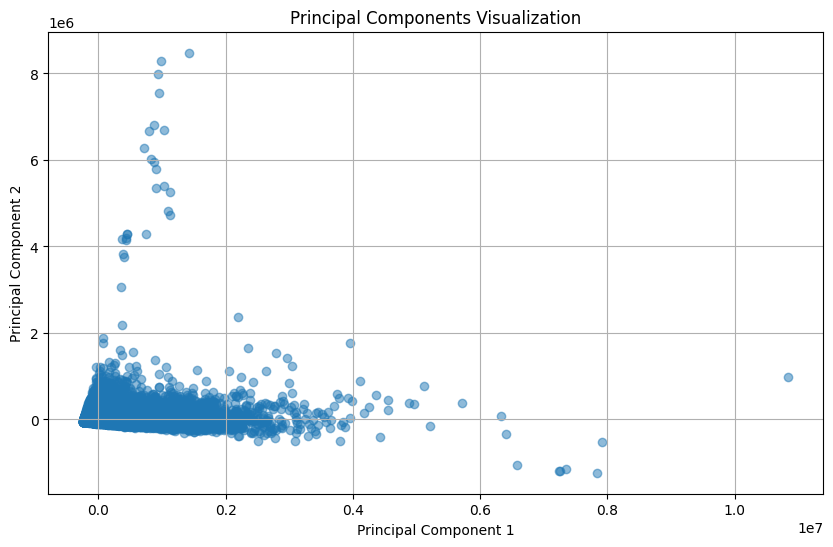

In [153]:
# Visualize Principal Components
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Components Visualization')
plt.grid(True)
plt.show()


In [255]:
import numpy as np

feature_names = X_train.columns # Exclude the target column
n_components = pca.components_.shape[0]

# Create a list to store the selected features for each principal component
selected_features = []

# Iterate over each principal component
for component_idx in range(n_components):
    # Get the absolute values of the component weights and sort them
    abs_weights = np.abs(pca.components_[component_idx])
    sorted_indices = np.argsort(abs_weights)[::-1]  # Reverse order to get descending

    # Get the top features for this component
    top_features = [feature_names[idx] for idx in sorted_indices]

    # Append the top features to the list
    selected_features.append(top_features)

# Print or use the selected_features list as needed
print(selected_features)


[['tot_hi_cred_lim', 'tot_cur_bal', 'annual_inc', 'total_bal_ex_mort', 'total_il_high_credit_limit', 'total_rev_hi_lim', 'avg_cur_bal', 'revol_bal', 'total_bc_limit', 'total_bal_il_smoothed', 'bc_open_to_buy', 'total_pymnt', 'total_pymnt_inv', 'funded_amnt', 'loan_amnt', 'funded_amnt_inv', 'total_rec_prncp', 'last_pymnt_amnt', 'emp_title', 'total_rec_int', 'max_bal_bc_smoothed', 'installment', 'recoveries', 'title_smoothed', 'delinq_amnt', 'mo_sin_old_rev_tl_op', 'tot_coll_amt', 'mo_sin_old_il_acct', 'collection_recovery_fee', 'total_acc', 'earliest_cr_line', 'num_il_tl', 'open_acc', 'num_sats', 'revol_util', 'mths_since_recent_bc', 'num_rev_accts', 'zip_code', 'mort_acc', 'home_ownership', 'num_bc_tl', 'mths_since_last_delinq_smoothed', 'mths_since_rcnt_il_smoothed', 'sub_grade', 'mo_sin_rcnt_rev_tl_op', 'all_util_smoothed', 'num_op_rev_tl', 'mo_sin_rcnt_tl', 'int_rate', 'num_bc_sats', 'num_actv_rev_tl', 'bc_util', 'total_rec_late_fee', 'num_rev_tl_bal_gt_0', 'mths_since_recent_revol_

#### Train the XGBoost Model

In [238]:
from xgboost import XGBClassifier

# Initialize XGBoost classifier
model = XGBClassifier()

# Train the classifier on the transformed data
model.fit(X_train, y_train)

# Optionally, you can evaluate the model on the training set
train_accuracy = model.score(X_train, y_train)
print("Accuracy on training set:", train_accuracy)


Accuracy on training set: 0.9999085196652227


In [52]:
from xgboost import XGBClassifier

# Initialize XGBoost classifier
model = XGBClassifier()

# Train the classifier on the transformed data
model.fit(X_selected, y_train)

# Optionally, you can evaluate the model on the training set
train_accuracy = model.score(X_selected, y_train)
print("Accuracy on training set:", train_accuracy)


Accuracy on training set: 0.9993372757969462


In [162]:
from xgboost import XGBClassifier

# Initialize XGBoost classifier
model = XGBClassifier()

# Train the classifier on the transformed data
model.fit(X, y_train)

# Optionally, you can evaluate the model on the training set
train_accuracy = model.score(X, y_train)
print("Accuracy on training set:", train_accuracy)


Accuracy on training set: 0.9993271113153043


In [64]:
from xgboost import XGBClassifier

# Initialize XGBoost classifier
model = XGBClassifier()

# Train the classifier on the transformed data
model.fit(X_modified, y_train)

# Optionally, you can evaluate the model on the training set
train_accuracy = model.score(X_modified, y_train)
print("Accuracy on training set:", train_accuracy)


Accuracy on training set: 0.9992925520777217


In [65]:
# make predictions for test data
y_pred = model.predict(X_valid_modified)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score( y_valid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.84%


In [62]:
import shap

In [66]:
# make predictions for test data
y_pred = model.predict(X_test_modified )
predictions = [round(value) for value in y_pred]
print(predictions)

[1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 

In [67]:
X_test_modified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172596 entries, 0 to 172595
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   term                         172596 non-null  int32  
 1   int_rate                     172596 non-null  float64
 2   installment                  172596 non-null  float64
 3   grade                        172596 non-null  int32  
 4   sub_grade                    172596 non-null  int32  
 5   emp_length                   172596 non-null  int32  
 6   home_ownership               172596 non-null  int32  
 7   verification_status          172596 non-null  int32  
 8   dti                          172596 non-null  float64
 9   inq_last_6mths               172596 non-null  float64
 10  initial_list_status          172596 non-null  int32  
 11  total_pymnt                  172596 non-null  float64
 12  total_rec_prncp              172596 non-null  float64
 13 

In [185]:
predictions_df = pd.DataFrame(predictions, columns=['predicted_column_name'])
combined_data = pd.concat([predictions_df, X_test_modified.reset_index(drop=True)], axis=1)



# Save to CSV file
combined_data.to_csv('210386A.csv', index=False)


In [252]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(X_valid, y_valid)
eli5.show_weights(perm, feature_names = X_valid.columns.tolist())

ModuleNotFoundError: No module named 'distutils'

In [69]:
from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

In [100]:
feature_names = X_modified.columns
print(feature_names)

Index(['term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'verification_status', 'dti', 'inq_last_6mths',
       'initial_list_status', 'total_pymnt', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'last_credit_pull_d', 'acc_open_past_24mths', 'mort_acc',
       'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'num_sats',
       'pub_rec_bankruptcies', 'debt_settlement_flag', 'purpose_smoothed',
       'open_rv_24m_smoothed', 'all_util_smoothed', 'inq_fi_smoothed',
       'open_acc_to_total_acc_ratio'],
      dtype='object')


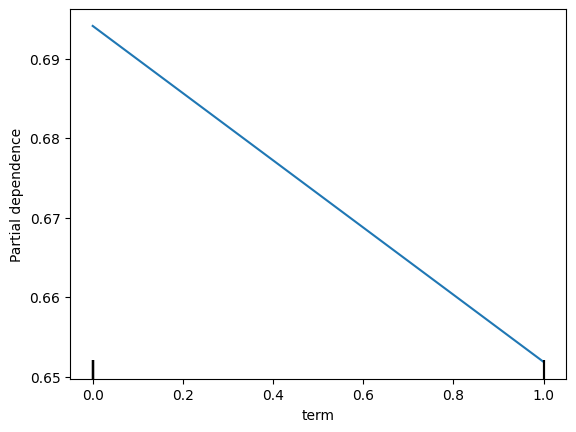

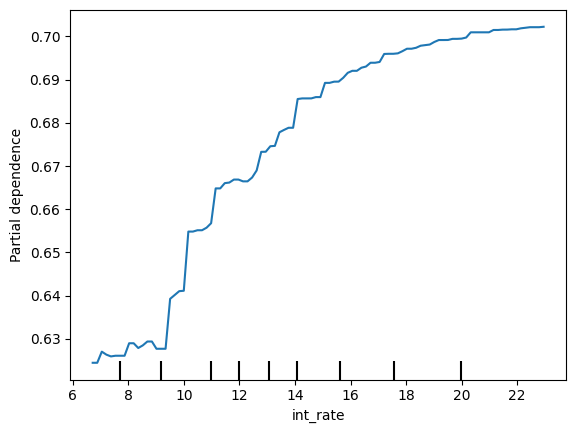

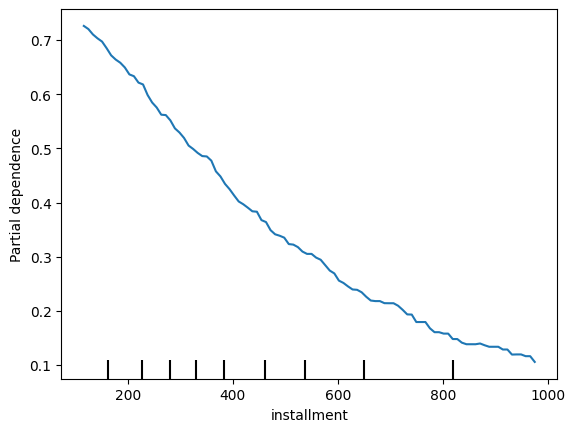

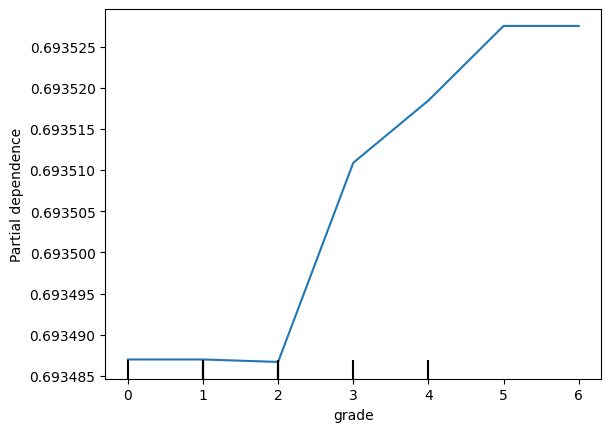

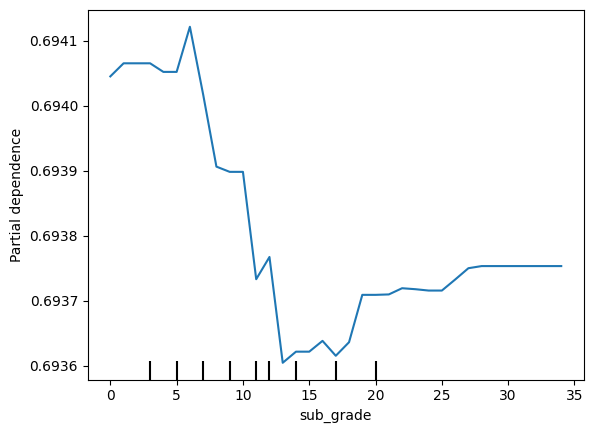

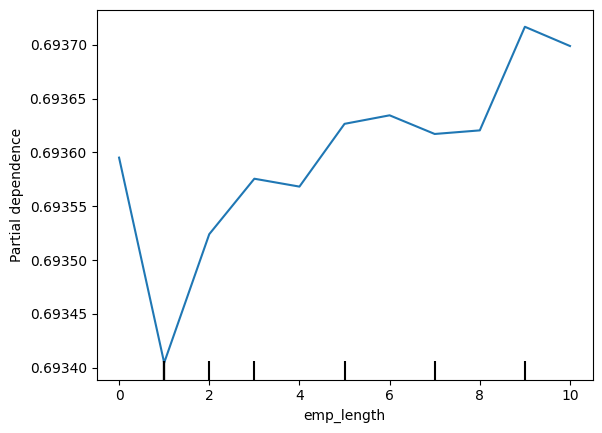

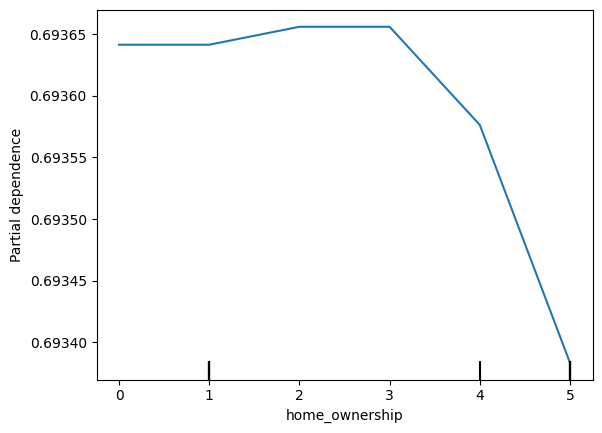

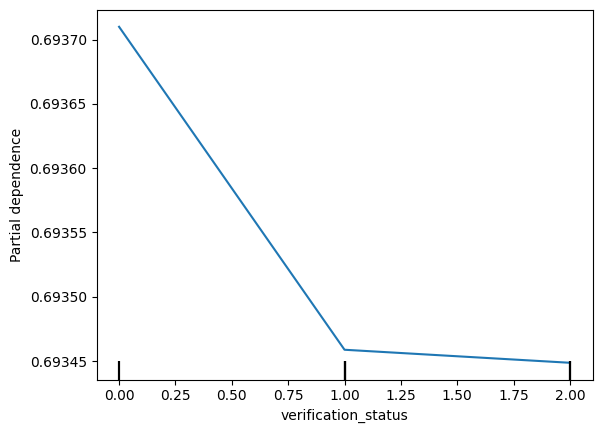

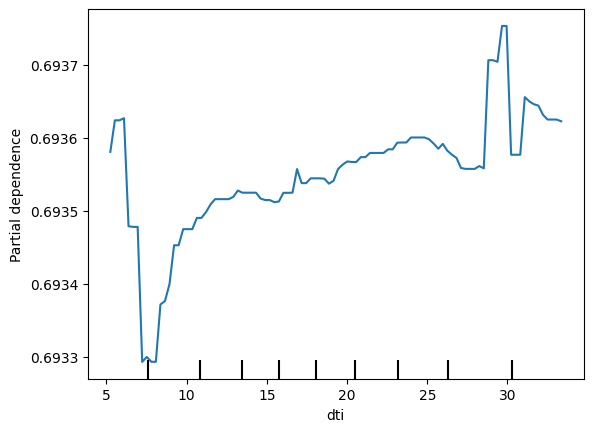

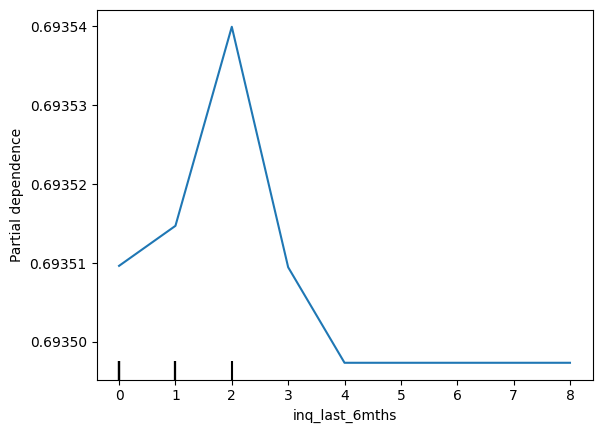

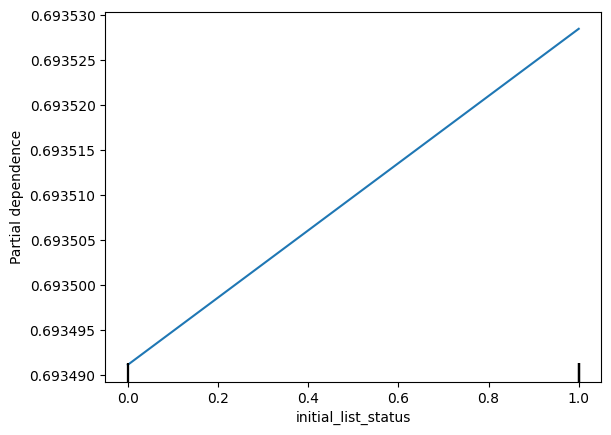

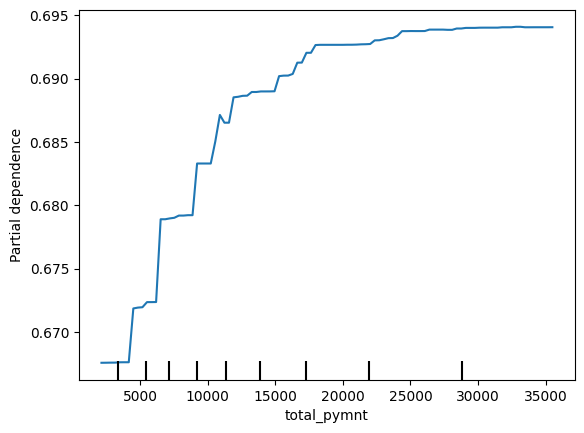

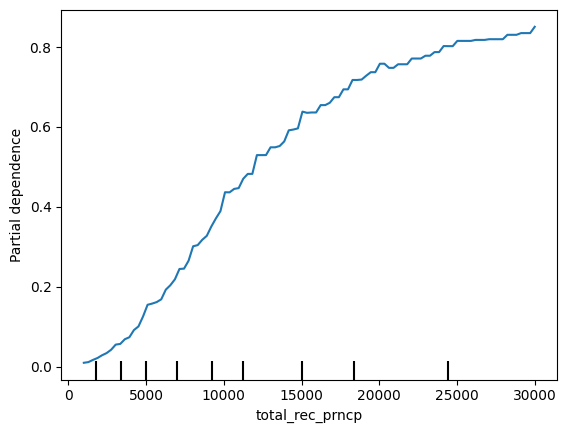

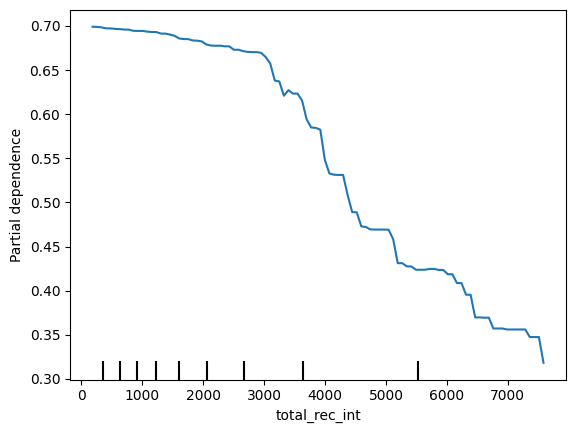

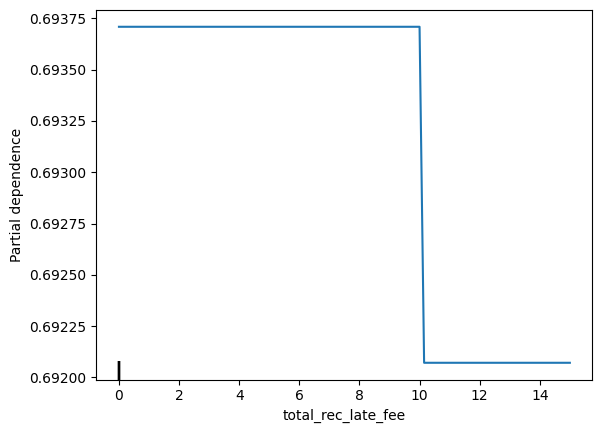

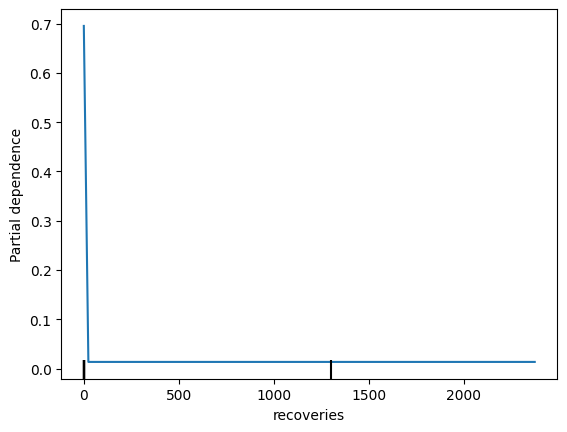

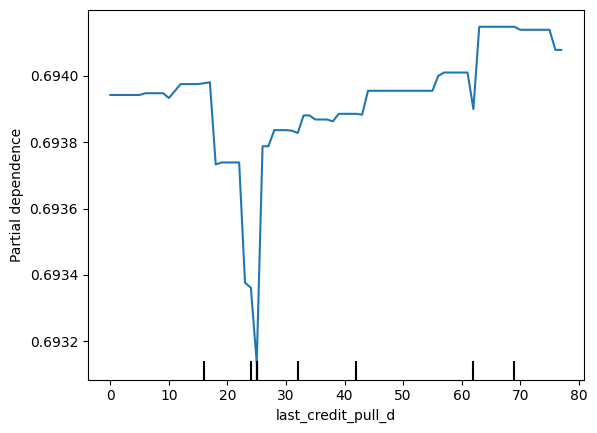

C:\Users\MadaraMendis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


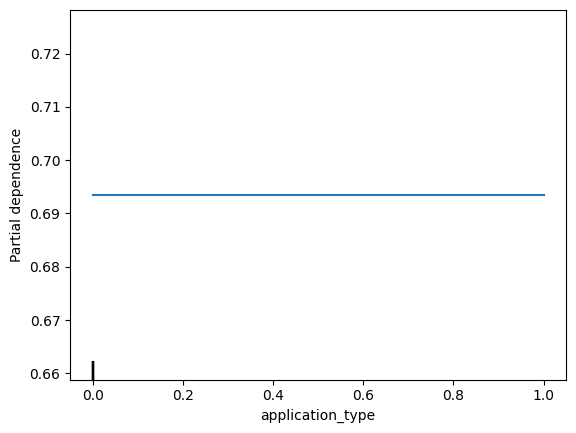

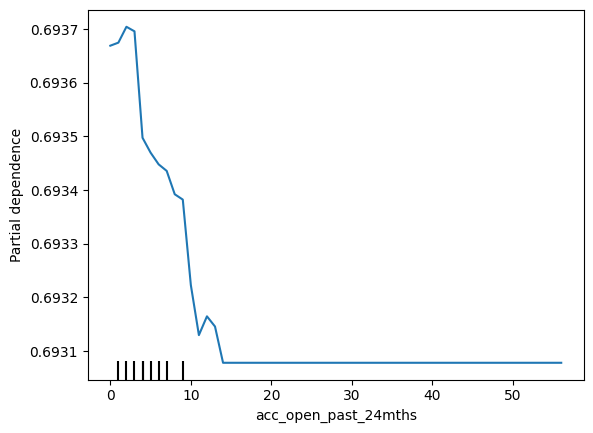

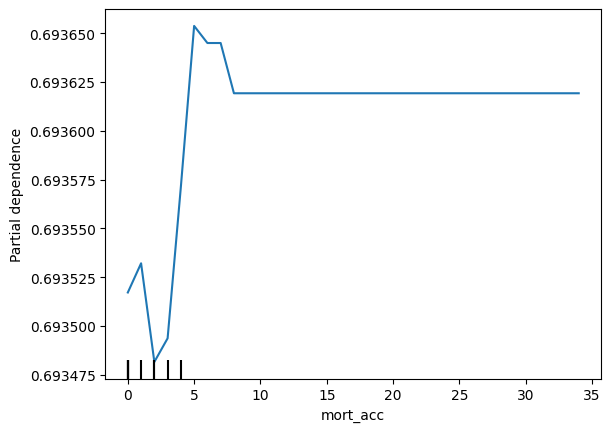

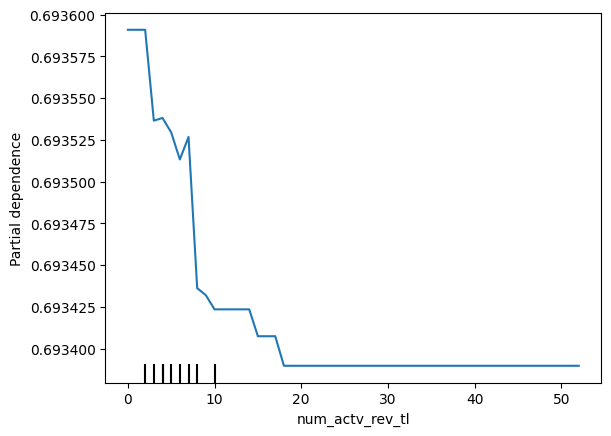

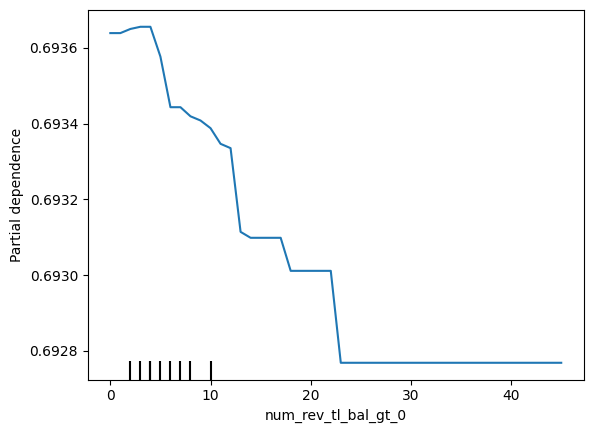

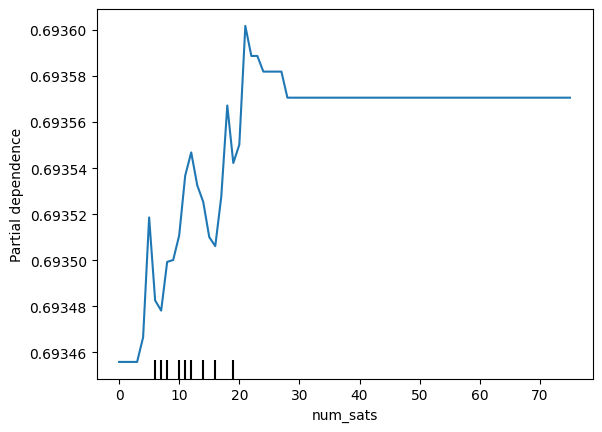

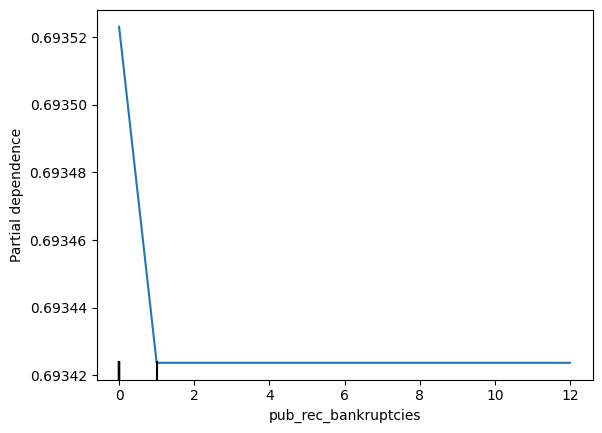

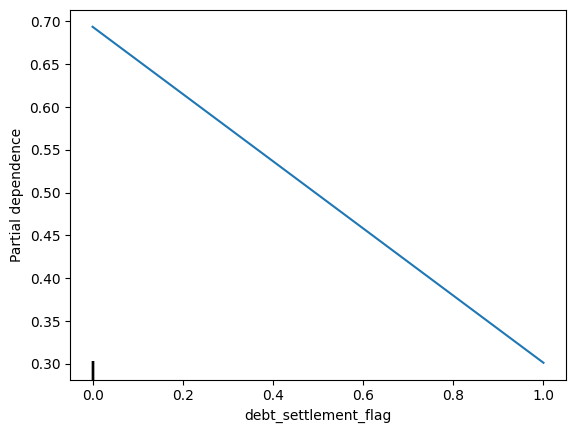

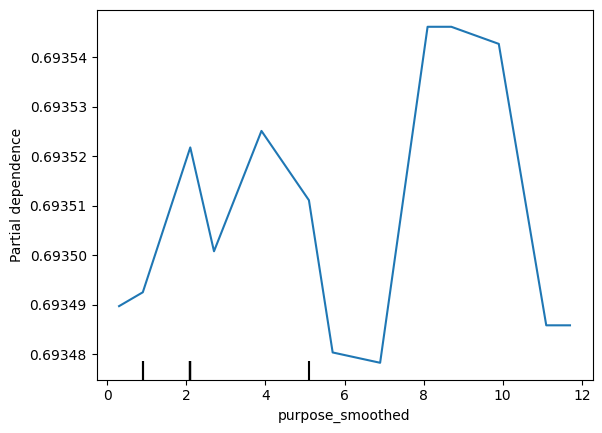

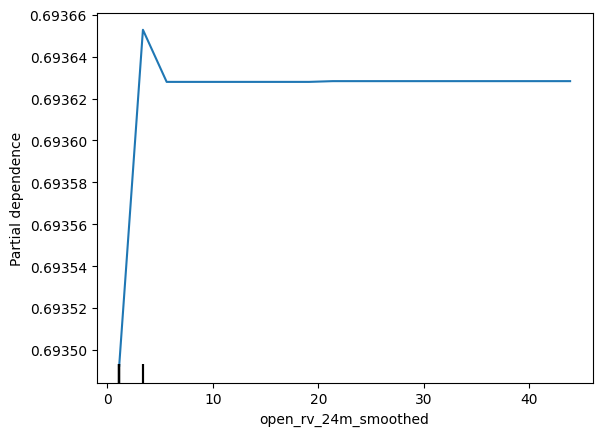

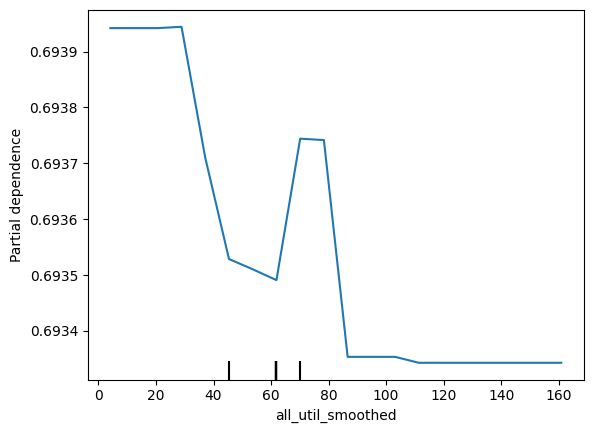

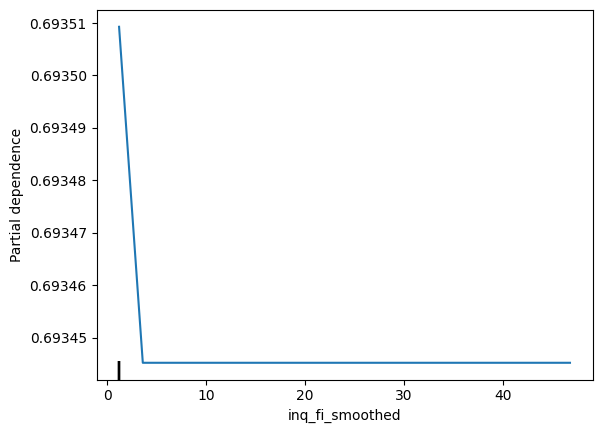

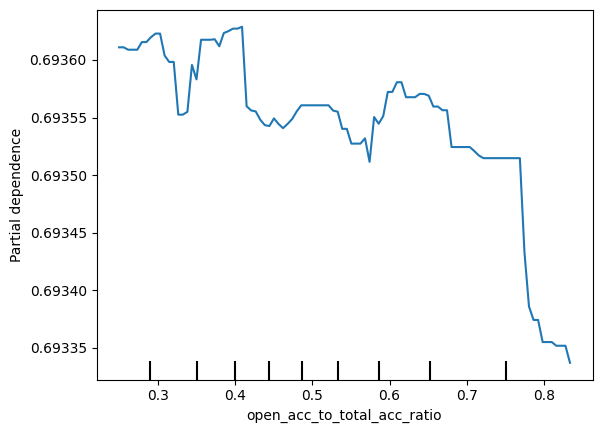

In [71]:
for feat_name in feature_names:
    PartialDependenceDisplay.from_estimator(model, X_modified, [feat_name])
    plt.show()

In [94]:
import shap

In [95]:
explainer = shap.TreeExplainer(model)

In [106]:
small_val_X = X_valid_modified.iloc[:163908]

In [107]:
print("Shape of SHAP values:", shap_values.shape)
print("Shape of feature matrix:", small_val_X.shape)


Shape of SHAP values: (163908, 29)
Shape of feature matrix: (163908, 29)


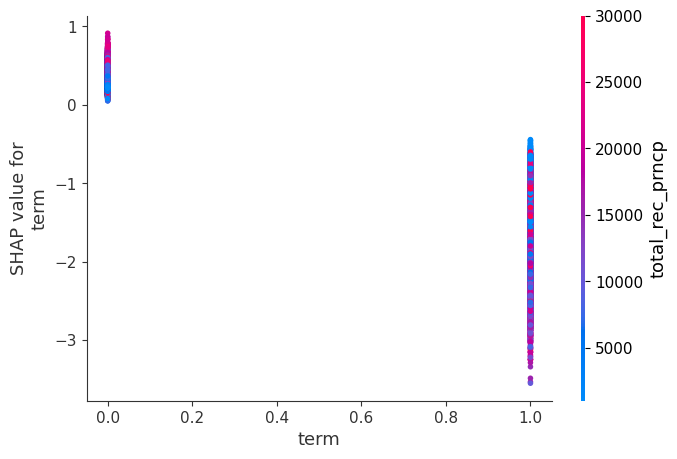

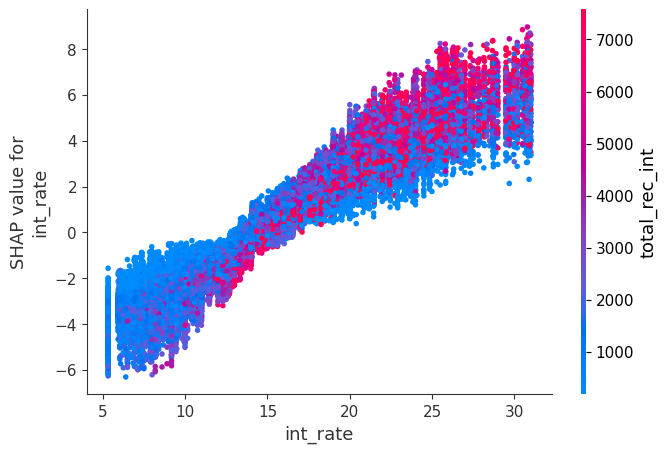

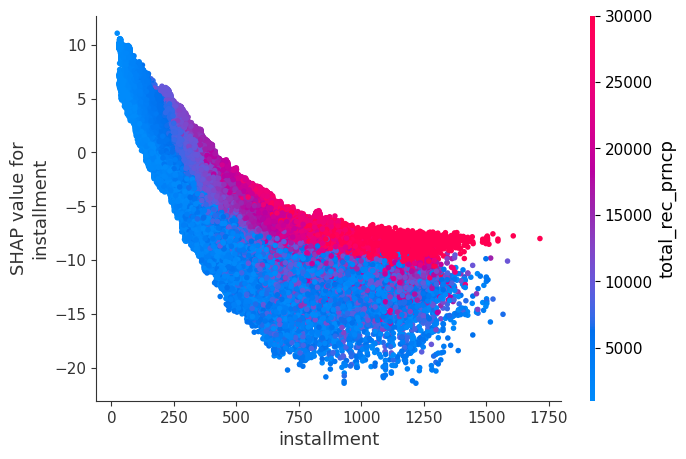

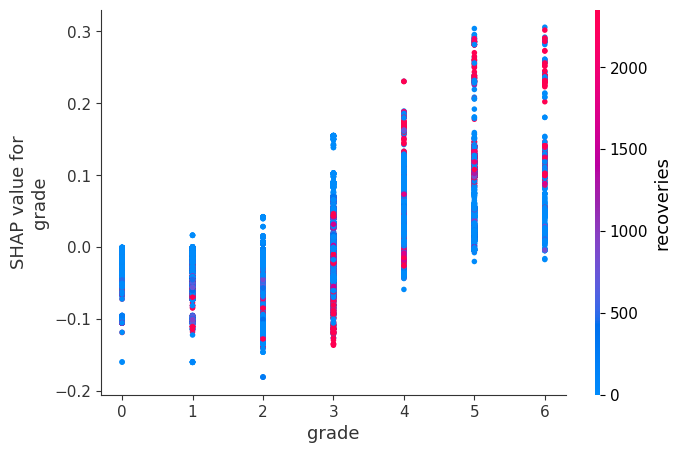

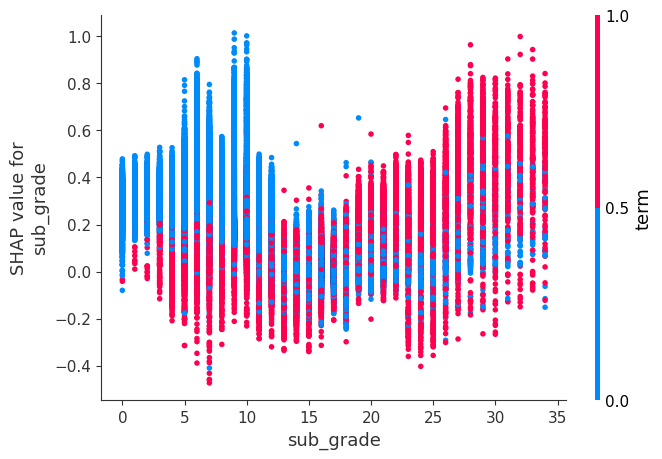

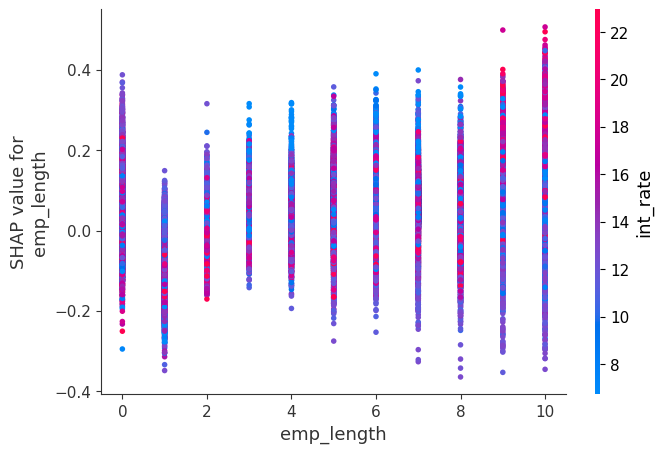

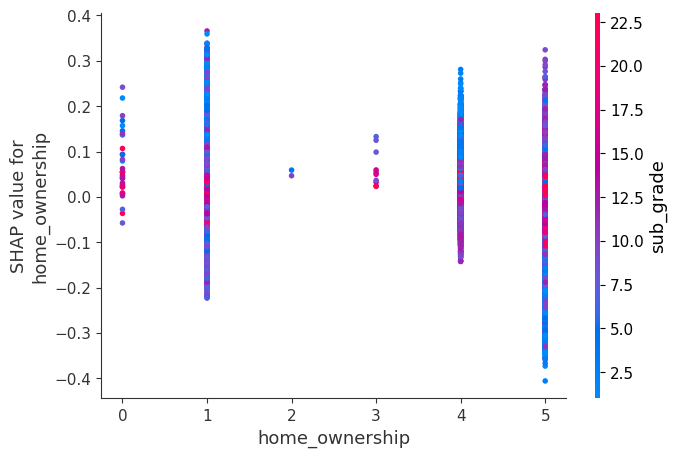

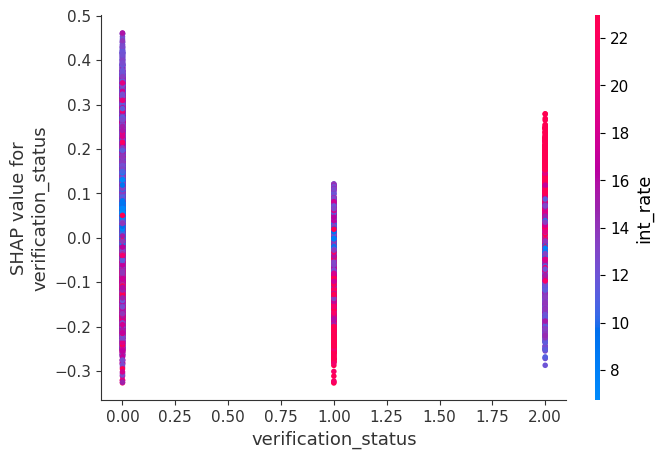

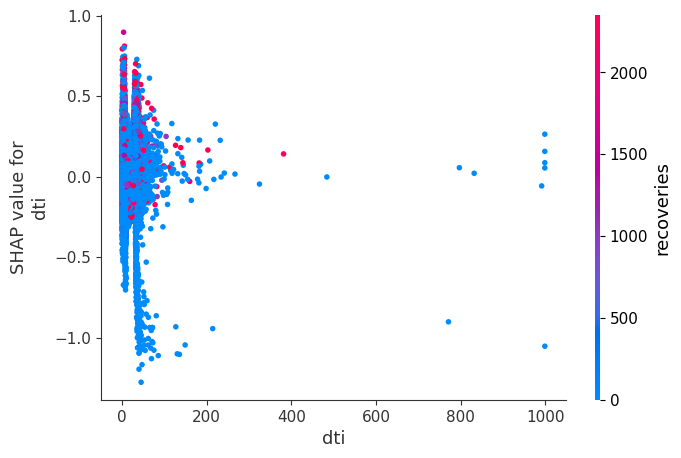

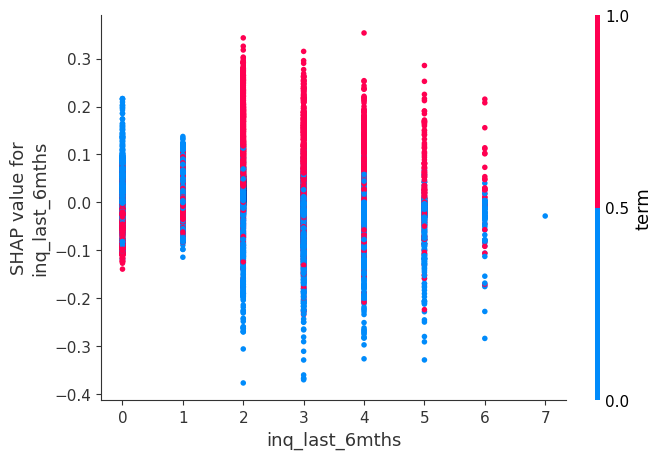

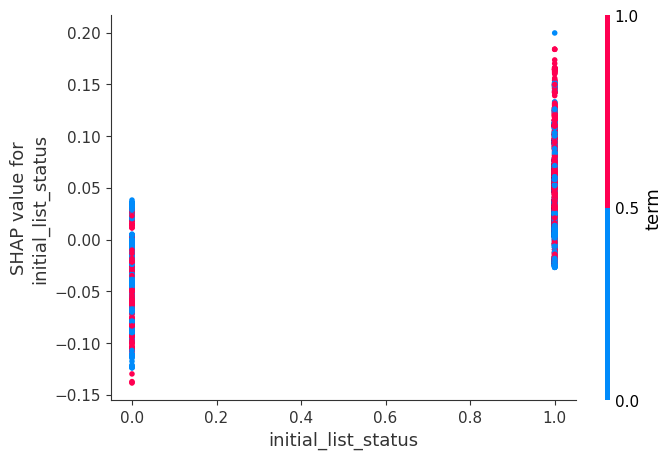

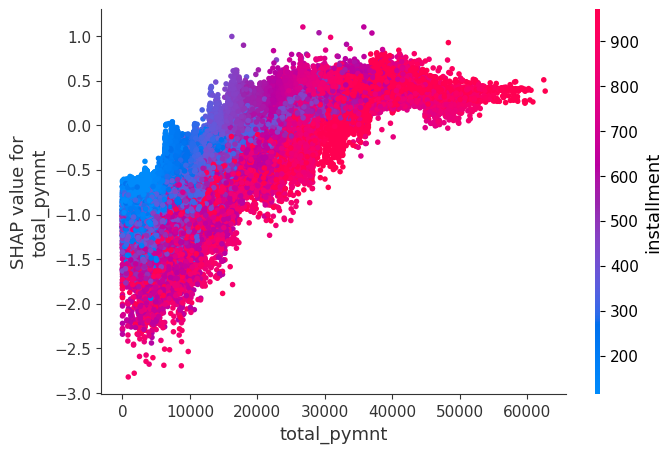

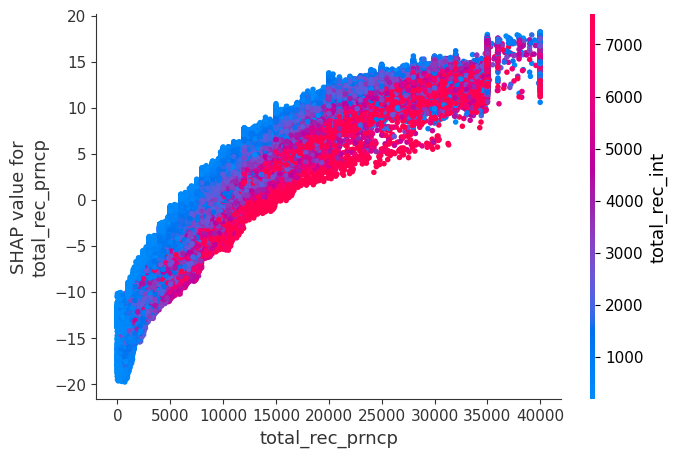

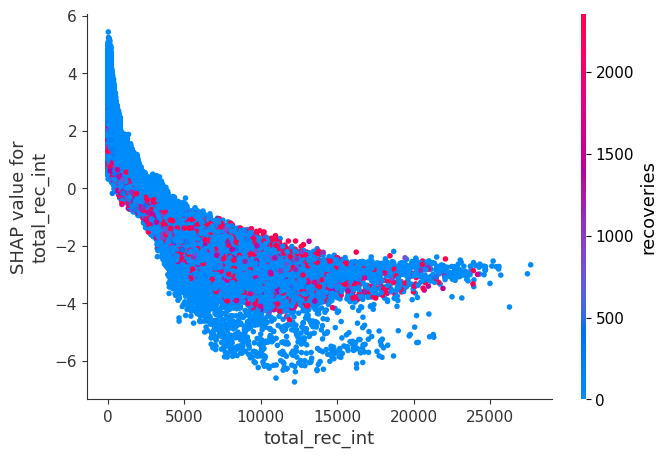

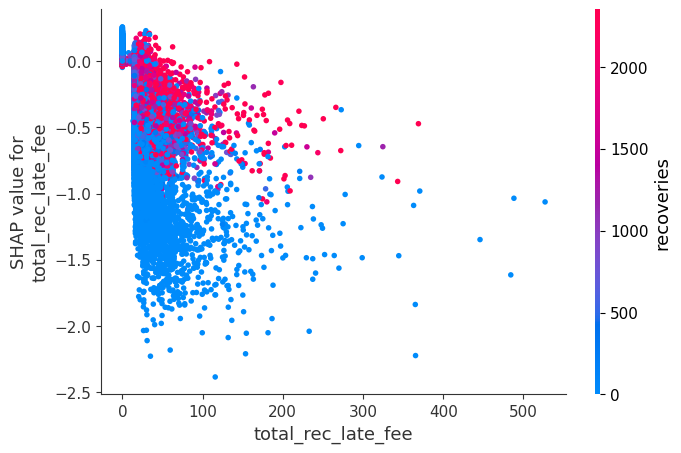

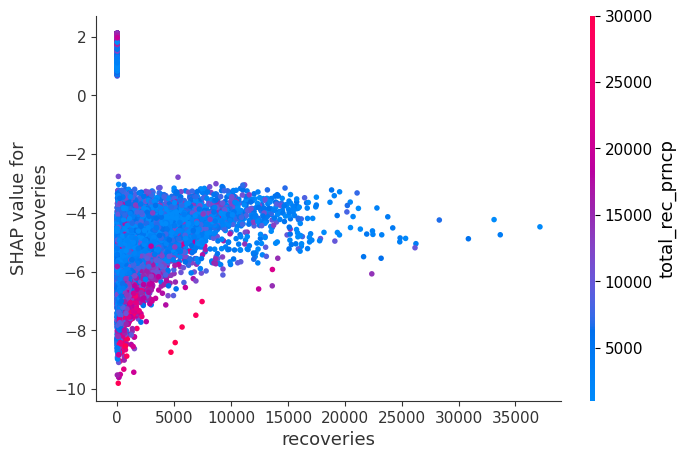

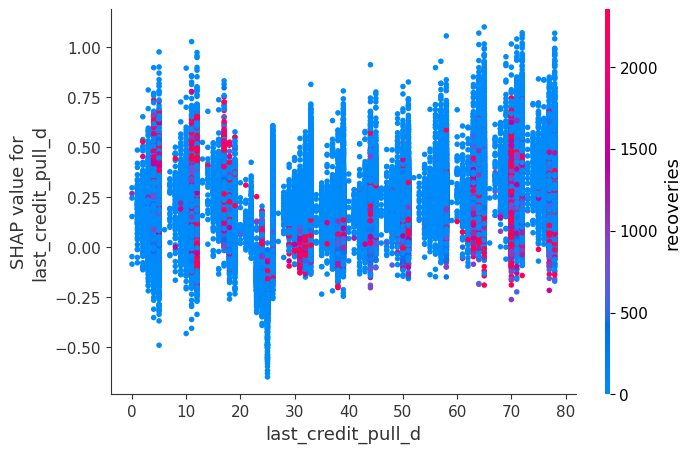

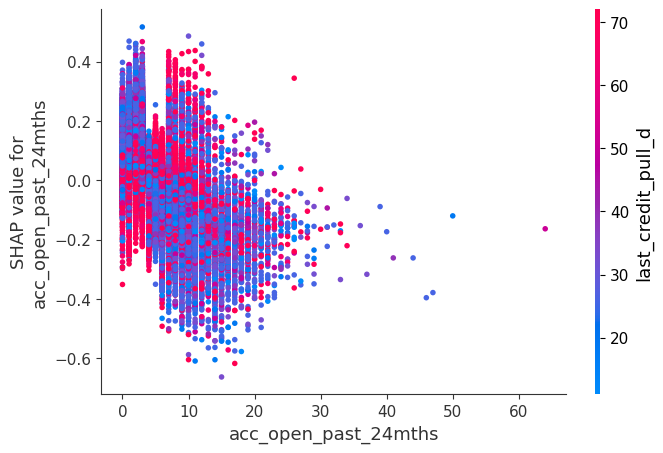

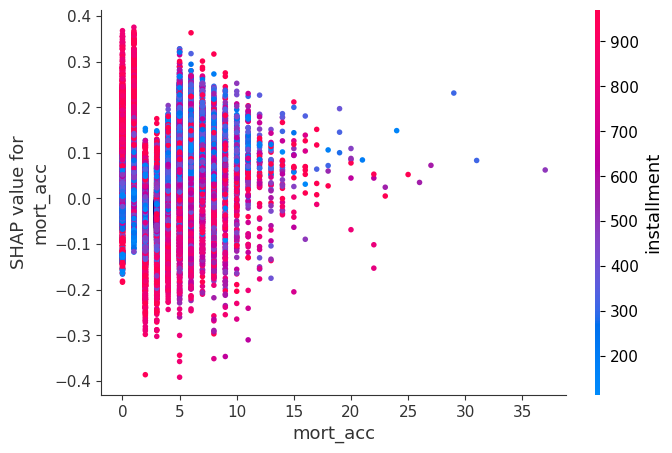

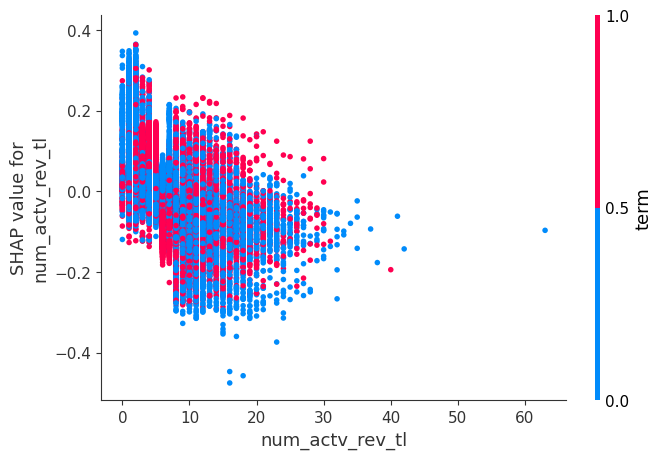

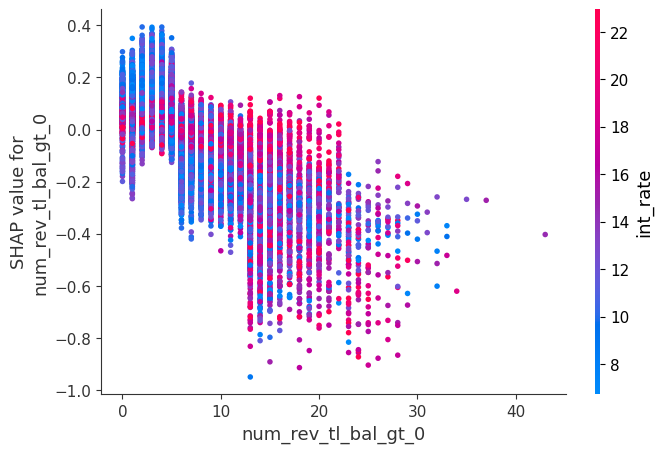

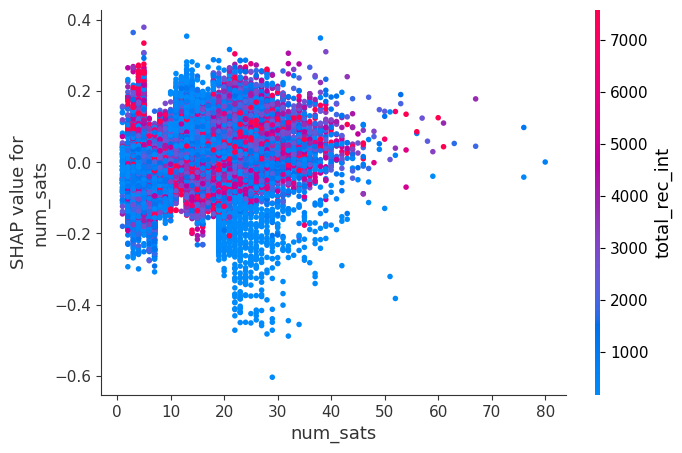

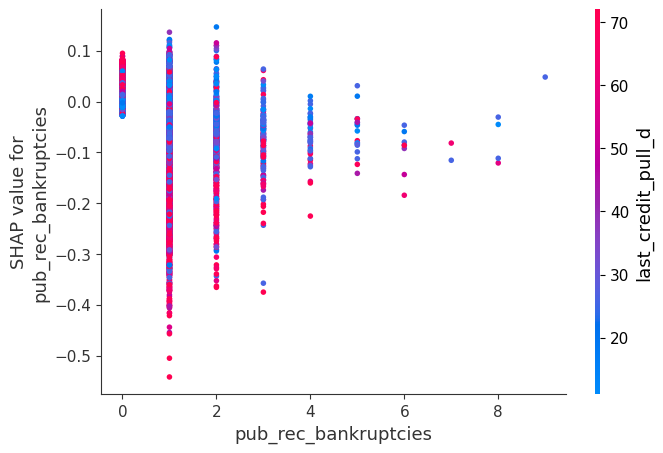

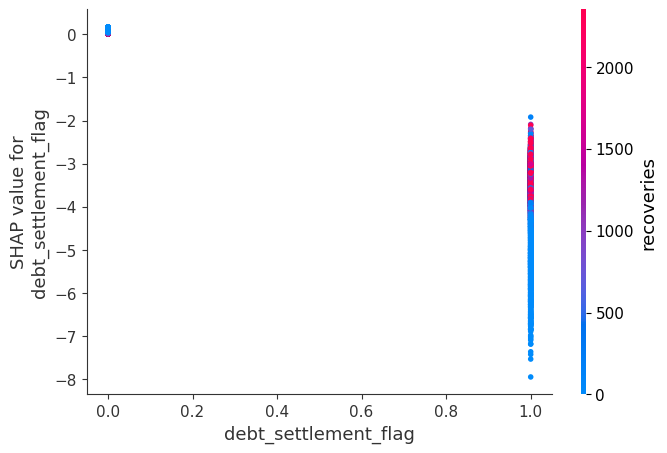

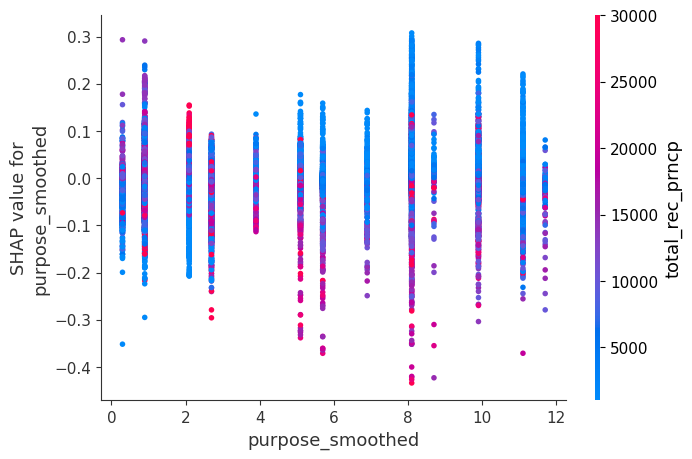

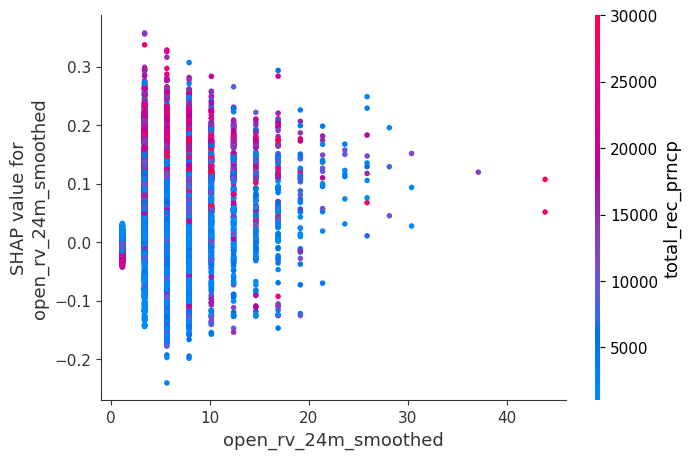

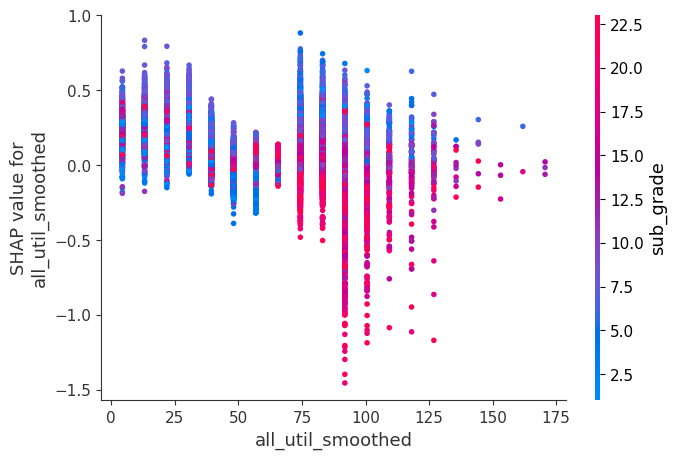

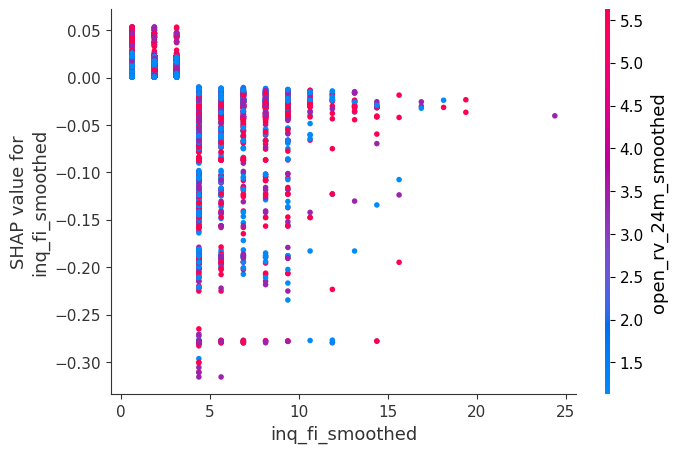

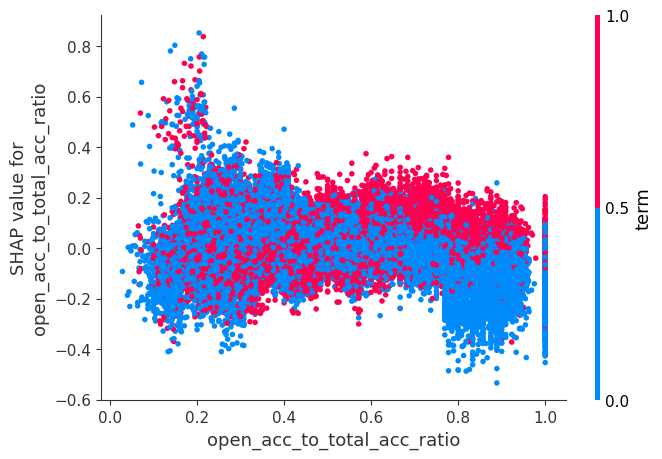

In [108]:
# Define the feature names
feature_names = small_val_X.columns.tolist()

# Create dependence plots for all features
for feature in feature_names:
    shap.dependence_plot(feature, shap_values, small_val_X, feature_names=feature_names)

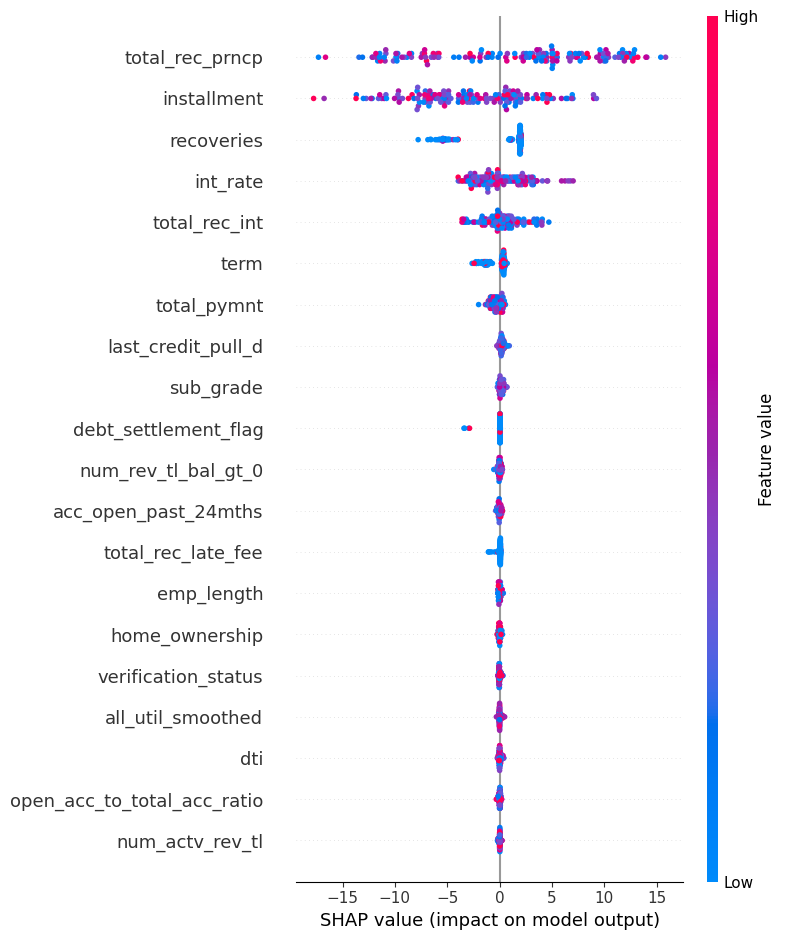

In [80]:
# Assuming shap_values is a vector
shap_values_matrix = shap_values.reshape(len(small_val_X), -1)
shap.summary_plot(shap_values_matrix, small_val_X)

In [64]:
row_to_show = 1
data_for_prediction = X_valid_modified.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired


In [71]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_valid_modified)
np.shape(shap_values.values)

(163908, 29)

#### Waterfall Plot

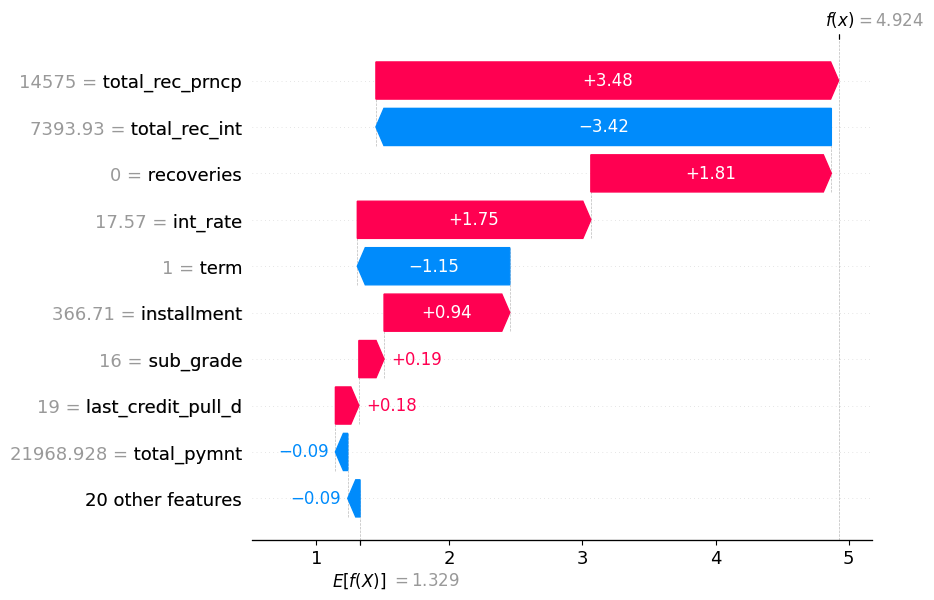

In [72]:
shap.plots.waterfall(shap_values[0])

####  Stacked Force plot

In [76]:
shap.plots.force(shap_values[0:100])

#### Force Plot

In [79]:
shap.plots.force(shap_values[0])

In [80]:
shap.plots.force(shap_values[50])

In [81]:
shap.plots.force(shap_values[100])

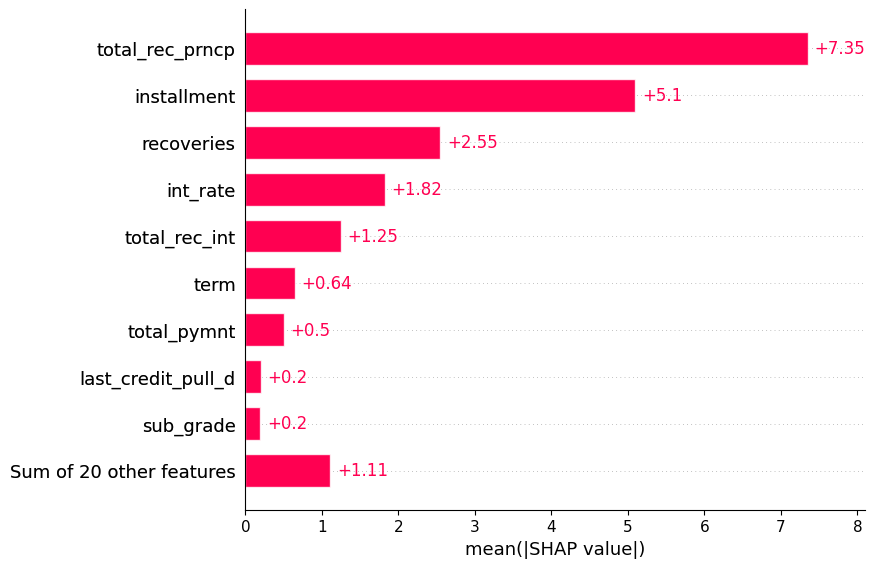

In [82]:
shap.plots.bar(shap_values)

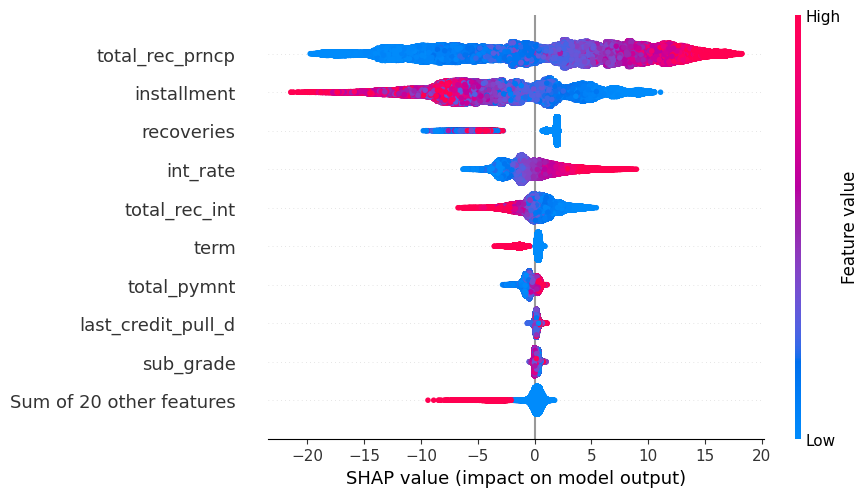

In [83]:
shap.plots.beeswarm(shap_values)

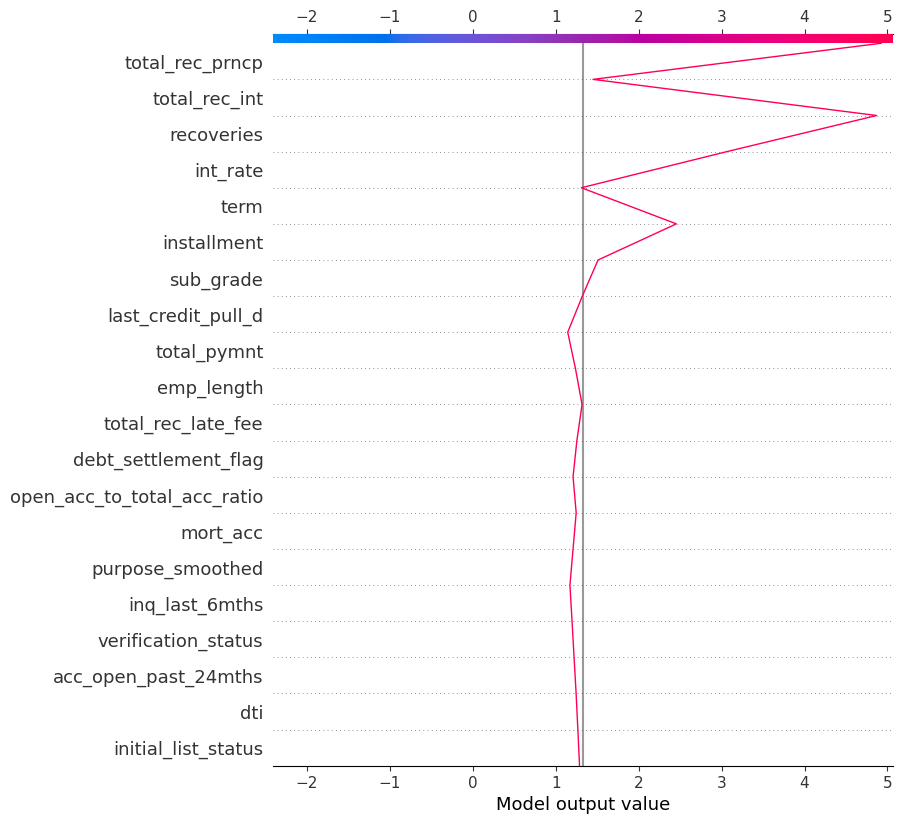

In [90]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid_modified)

feature_names = list(X_valid_modified.columns)

# Plot decision plot for the first sample (index 0)
shap.decision_plot(explainer.expected_value, shap_values[0], feature_names=feature_names)